In [155]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
import numpy as np
from Classification.cnn1D_model import VibrationDataset, CNN1D_DS
from Classification.cnn1D_model import train_and_evaluate, train_and_evaluate_with_kfold
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from utils.baseline_xai import predict_single, summarize_attributions
from utils.baseline_xai import grad_times_input_relevance, smoothgrad_relevance, occlusion_signal_relevance, occlusion_simpler_relevance
from  visualization.relevance_visualization import visualize_with_label_attribution, visualize_lrp_single_sample, visualize_lrp_dft, visualize_lrp_fft
from utils.xai_implementation import compute_lrp_relevance, compute_dft_lrp_relevance, compute_fft_lrp_relevance
from sklearn.model_selection import GroupKFold
from collections import Counter

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [59]:
# Load dataset, Stratify based on Lable and Operation, so that the train, test, val sets have appropriate amount of each group

data_directory = "../data/final/new_selection/normalized_windowed_downsampled_data"
dataset = VibrationDataset(data_directory, augment_bad=False)

# Create a combined stratification key (label_operation)
stratify_key = [f"{lbl}_{op}" for lbl, op in zip(dataset.labels, dataset.operations)]

# Stratified split by both label and operation
train_idx, temp_idx = train_test_split(
    range(len(dataset)), test_size=0.3, stratify=stratify_key
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=[stratify_key[i] for i in temp_idx]
)

# Create Subset datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

# Verify split sizes and label distribution
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")
print(f"Train good: {sum(dataset.labels[train_idx] == 0)}, Train bad: {sum(dataset.labels[train_idx] == 1)}")
print(f"Val good: {sum(dataset.labels[val_idx] == 0)}, Val bad: {sum(dataset.labels[val_idx] == 1)}")
print(f"Test good: {sum(dataset.labels[test_idx] == 0)}, Test bad: {sum(dataset.labels[test_idx] == 1)}")

# Class ratios
train_ratio = sum(dataset.labels[train_idx] == 0) / sum(dataset.labels[train_idx] == 1)
val_ratio = sum(dataset.labels[val_idx] == 0) / sum(dataset.labels[val_idx] == 1)
test_ratio = sum(dataset.labels[test_idx] == 0) / sum(dataset.labels[test_idx] == 1)
print(f"Class ratio (good/bad) - Train: {train_ratio:.2f}, Val: {val_ratio:.2f}, Test: {test_ratio:.2f}")

# Operation distribution
train_ops = Counter(dataset.operations[train_idx])
val_ops = Counter(dataset.operations[val_idx])
test_ops = Counter(dataset.operations[test_idx])
print(f"Train operations: {train_ops}")
print(f"Val operations: {val_ops}")
print(f"Test operations: {test_ops}")

# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train size: 5250, Val size: 1125, Test size: 1126
Train good: 3924, Train bad: 1326
Val good: 839, Val bad: 286
Test good: 843, Test bad: 283
Class ratio (good/bad) - Train: 2.96, Val: 2.93, Test: 2.98
Train operations: Counter({np.str_('OP06'): 806, np.str_('OP04'): 694, np.str_('OP10'): 568, np.str_('OP12'): 559, np.str_('OP02'): 551, np.str_('OP11'): 534, np.str_('OP08'): 442, np.str_('OP14'): 330, np.str_('OP01'): 321, np.str_('OP07'): 279, np.str_('OP05'): 166})
Val operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 148, np.str_('OP10'): 121, np.str_('OP12'): 120, np.str_('OP02'): 119, np.str_('OP11'): 114, np.str_('OP08'): 94, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 36})
Test operations: Counter({np.str_('OP06'): 173, np.str_('OP04'): 149, np.str_('OP10'): 122, np.str_('OP12'): 119, np.str_('OP02'): 118, np.str_('OP11'): 115, np.str_('OP08'): 95, np.str_('OP14'): 71, np.str_('OP01'): 69, np.str_('OP07'): 60, np.str_('OP05'): 35})


Using device: cuda
Epoch [1/20] - Train Loss: 0.4434, Train Acc: 0.7884 - Val Loss: 0.2155, Val Acc: 0.9387 
Epoch [2/20] - Train Loss: 0.1091, Train Acc: 0.9701 - Val Loss: 0.0501, Val Acc: 0.9876 
Epoch [3/20] - Train Loss: 0.0401, Train Acc: 0.9890 - Val Loss: 0.0254, Val Acc: 0.9947 
Epoch [4/20] - Train Loss: 0.0396, Train Acc: 0.9876 - Val Loss: 0.0783, Val Acc: 0.9724 
Epoch [5/20] - Train Loss: 0.0259, Train Acc: 0.9924 - Val Loss: 0.0473, Val Acc: 0.9831 
Epoch [6/20] - Train Loss: 0.0242, Train Acc: 0.9937 - Val Loss: 0.0151, Val Acc: 0.9973 
Epoch [7/20] - Train Loss: 0.0147, Train Acc: 0.9964 - Val Loss: 0.0156, Val Acc: 0.9973 
Epoch [8/20] - Train Loss: 0.0377, Train Acc: 0.9878 - Val Loss: 0.0223, Val Acc: 0.9947 
Epoch [9/20] - Train Loss: 0.0205, Train Acc: 0.9945 - Val Loss: 0.0222, Val Acc: 0.9929 
Early stopping triggered at epoch 9
Restored best model weights from epoch with Val Loss: 0.0151
✅ Training and validation complete!
🔥 Test F1 Score: 0.9938, Test Accuracy

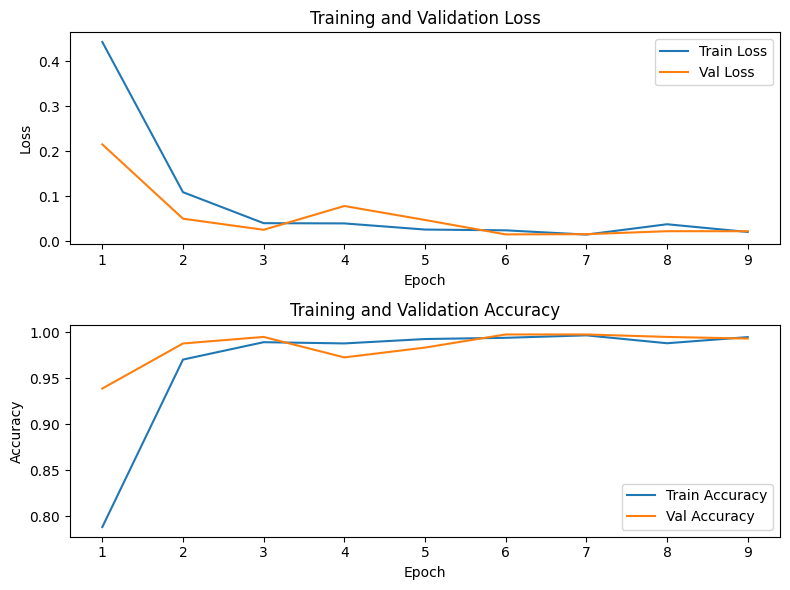

In [68]:
# ------------------------
#  Run Training & Evaluation
# ------------------------
# model = train_and_evaluate(train_loader, val_loader, test_loader)
best_model = train_and_evaluate(train_loader, val_loader, test_loader, EralyStopping=True)



In [69]:
# Save the trained model
torch.save(best_model.state_dict(), "../cnn1d_model.ckpt")
print("✅ Model saved to cnn1d_model.ckpt")
best_model.to(device)
best_model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")
print(f"✅ Model is structured as  \n {best_model}")


✅ Model saved to cnn1d_model.ckpt
✅ Model loaded and ready for explanations
✅ Model is structured as  
 CNN1D_DS(
  (conv1): Conv1d(3, 16, kernel_size=(9,), stride=(1,))
  (gn1): GroupNorm(4, 16, eps=1e-05, affine=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
  (gn2): GroupNorm(4, 32, eps=1e-05, affine=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (gn3): GroupNorm(4, 64, eps=1e-05, affine=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


### Explain the Model

#### choose a good sample

In [71]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(test_loader))

# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(best_model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}, True_label:{label}")
print(sample, sample.shape)


Random Index: 112, Predicted_label:0, True_label:0
tensor([[ 0.0113,  0.0846,  0.0296,  ...,  0.1395,  0.4863,  1.1009],
        [ 1.3112,  1.0182,  1.0560,  ...,  0.1739, -0.4082,  0.0975],
        [-0.0511,  0.0812, -0.2225,  ..., -0.1093, -0.0190,  0.1042]],
       device='cuda:0') torch.Size([3, 2000])


#### DFT-LRP implementation

In [209]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_dft_lrp_relevance(
        model=best_model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
Weight shape in create_fourier_weights: (2000, 2000)
Raw weight shape from dft_utils: (2000, 2000)
Weight shape after tensor conversion: torch.Size([2000, 2000])
3
1001
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: torch.Size([1, 2000])
Input signal shape: (1, 2000)
Input relevance shape: (1, 2000)
Signal hat shape after transform: torch.Size([1, 2000])
Relevance hat shape before multiplication: torch.Size([1, 2000])
Relevance hat shape after multiplication: to

E:\Thesis\Datasets\CNC\utils\dft_lrp.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Min relevance: -0.17321093380451202, Max relevance: 0.037472378462553024
 Maximum Absolute Attribution in Axis 0: 0.037472378462553024
 Maximum Absolute Attribution in Axis 1: 0.034186650067567825
 Maximum Absolute Attribution in Axis 2: 0.17321093380451202


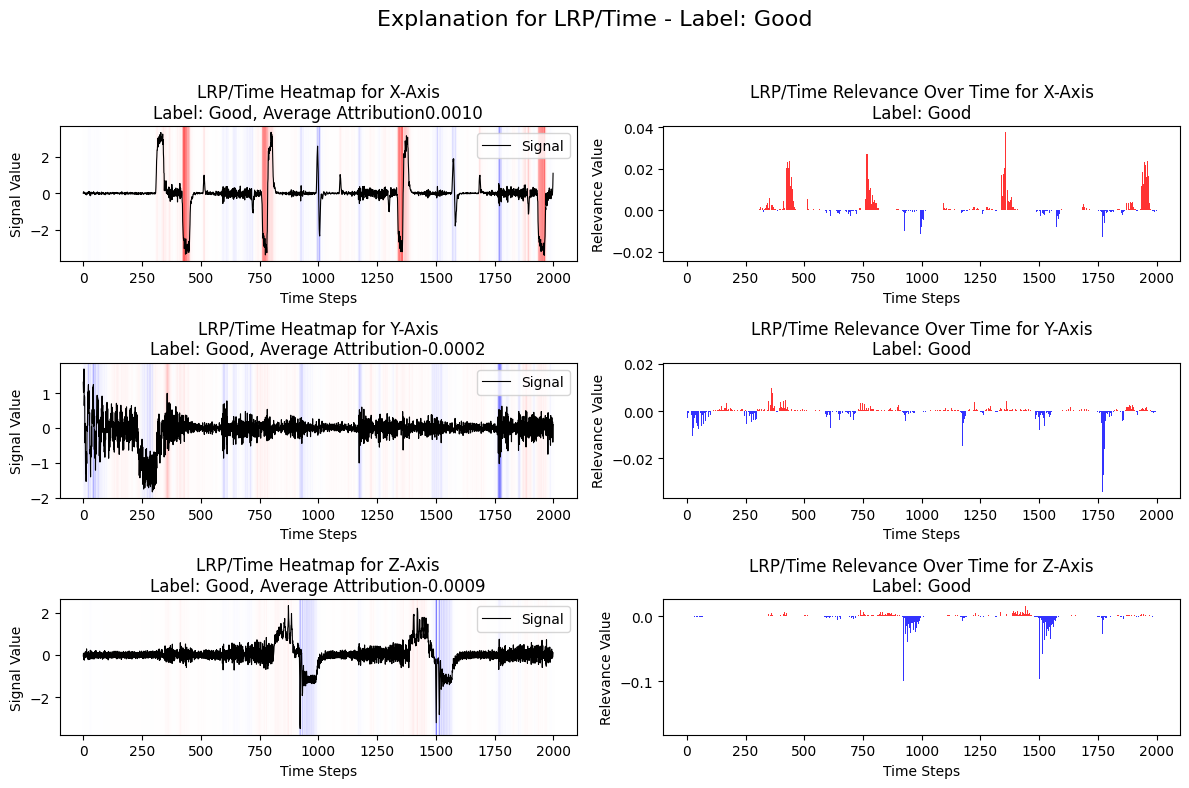

In [210]:
# LRP visualization with mutual visualization function
print(f"Min relevance: {np.min(relevance_time)}, Max relevance: {np.max(relevance_time)}")
visualize_with_label_attribution(sample, relevance_time, label, "LRP/Time")


In [211]:
""# Global Attribution over frequency with LRP
summary_lrp_freq = summarize_attributions(relevance_freq)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_freq = []
for axis, values in summary_lrp_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_freq.append(row)

# Create the DataFrame
df_summary_lrp_freq = pd.DataFrame(data_lrp_freq)

# Display the DataFrame as a table
print(df_summary_lrp_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             503                  2.771116   
1  Axis 1             494                  0.645275   
2  Axis 2             420                  0.728617   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.005509             498                 -0.787351   
1                    0.001306             507                 -1.031781   
2                    0.001735             581                 -2.604509   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001581                     1.983765   
1                   -0.002035                    -0.386505   
2                   -0.004483                    -1.875892   

   Average Relevance (Pos + Neg)  
0                       0.001982  
1                      -0.000386  
2                      -0.001874  


In [212]:
""# Global Attribution over frequency with LRP
summary_lrp_t = summarize_attributions(relevance_time)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t = []
for axis, values in summary_lrp_t.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t.append(row)

# Create the DataFrame
df_summary_lrp_t = pd.DataFrame(data_lrp_t)

# Display the DataFrame as a table
print(df_summary_lrp_t)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1291                  2.670801   
1  Axis 1            1315                  0.827866   
2  Axis 2            1323                  1.678833   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.002069             709                 -0.688620   
1                    0.000630             685                 -1.219645   
2                    0.001269             677                 -3.555342   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000971                     1.982181   
1                   -0.001781                    -0.391778   
2                   -0.005252                    -1.876509   

   Average Relevance (Pos + Neg)  
0                       0.000991  
1                      -0.000196  
2                      -0.000938  


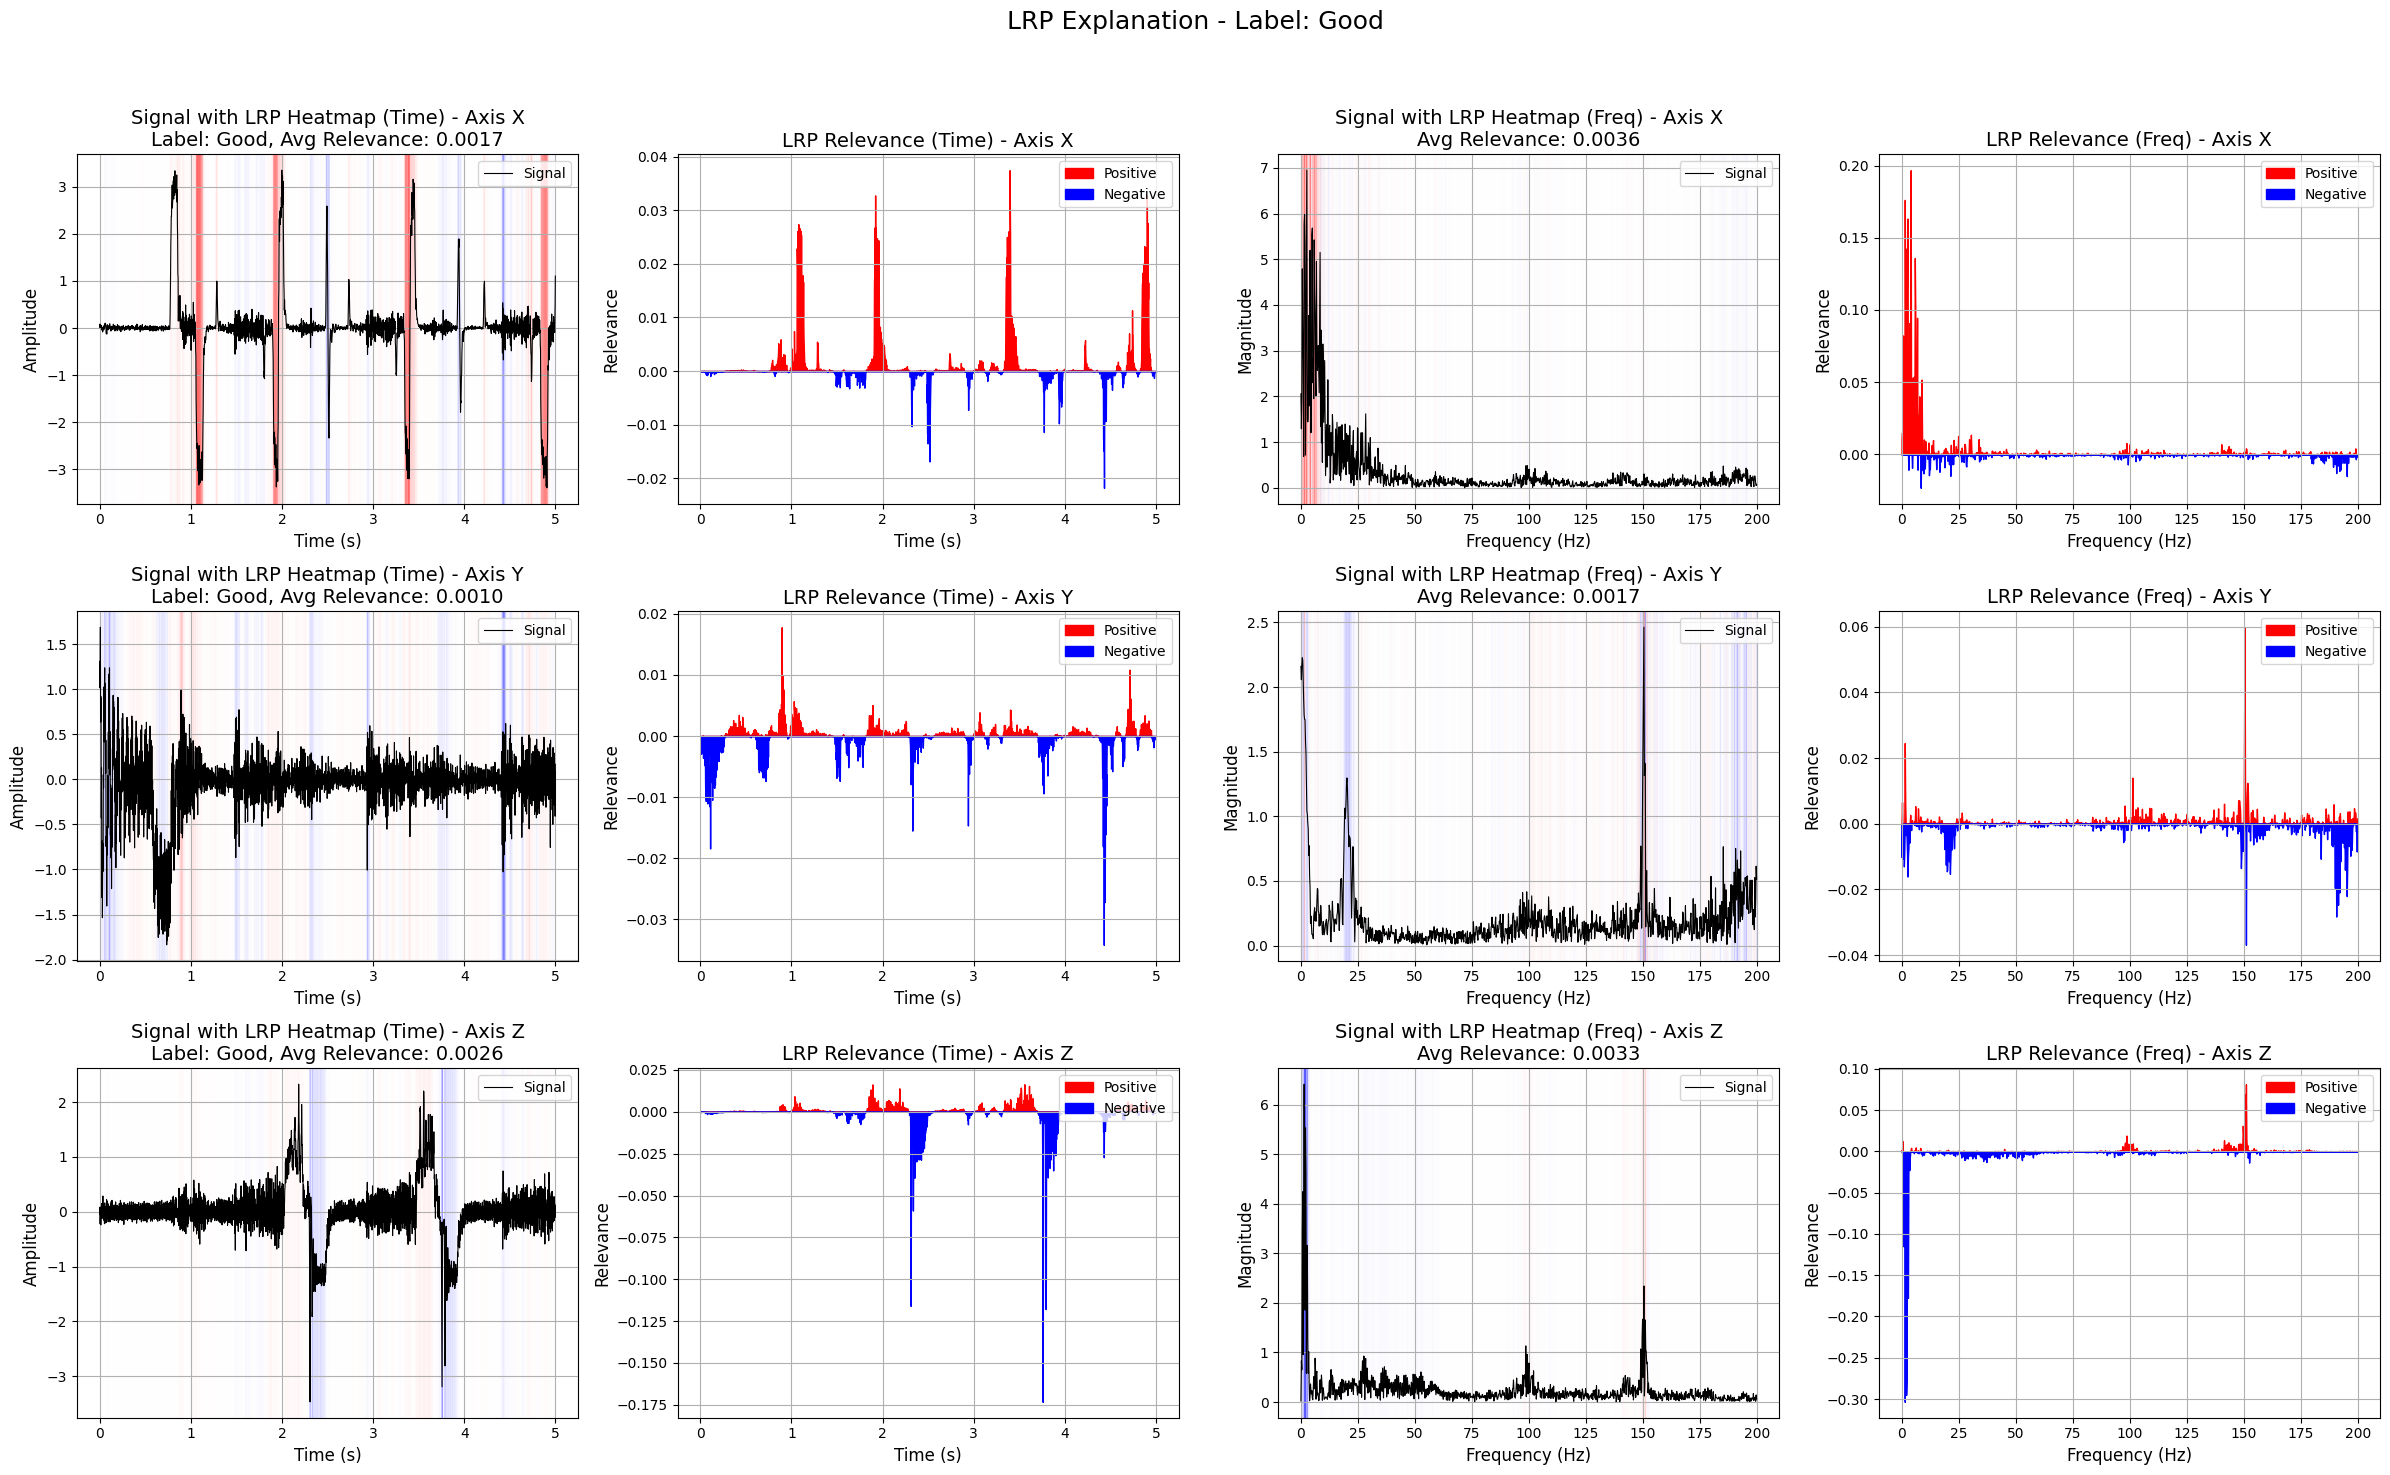

In [213]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [ ]:
# LRP visualization with common visualization function
 # write something similar to the common visualization for the frequency, so the relevance are colored over fft/dft signals
# in compute_dft_lrp_relevance why freqs are calculated by fft not dft?

#### FFT-LRP implementation

In [206]:
relevance_time_fft, relevance_freq_fft, signal_freq_fft, relevance_timefreq_fft, signal_timefreq_fft, input_signal_fft, freqs_fft, predicted_label_fft = compute_fft_lrp_relevance(
        model=best_model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=64,  # Increased to reduce memory usage
        window_width=128,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[-0.0051, -0.0057, -0.0028,  ..., -0.0038, -0.0095, -0.0134]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[0.0000, 0.0025, 0.0008,  ..., 0.0067, 0.0048, 0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[ 0.005

In [207]:
# Global Attribution for FFT_LRP over frequency
summary_fft_freq = summarize_attributions(relevance_freq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_freq = []
for axis, values in summary_fft_freq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_freq.append(row)

# Create the DataFrame
df_summary_fft_freq = pd.DataFrame(data_fft_freq)

# Display the DataFrame as a table
print(df_summary_fft_freq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             503        1.672893+0.000000j   
1  Axis 1             494        1.519914+0.000000j   
2  Axis 2             420        1.284361+0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.003326+0.000000j             498       -1.735851+0.000000j   
1          0.003077+0.000000j             507       -1.746964+0.000000j   
2          0.003058+0.000000j             581       -1.981203+0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.003486+0.000000j          -0.062957+0.000000j   
1         -0.003446+0.000000j          -0.227049+0.000000j   
2         -0.003410+0.000000j          -0.696842+0.000000j   

   Average Relevance (Pos + Neg)  
0            -0.000063+0.000000j  
1            -0.000227+0.000000j  
2            -0.000696+0.000000j  


In [94]:
# Global Attribution for FFT_LRP over time frequency
summary_fft_timefreq = summarize_attributions(relevance_timefreq_fft)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_fft_timefreq = []
for axis, values in summary_fft_timefreq.items():
    row = {"Axis": axis}
    row.update(values)
    data_fft_timefreq.append(row)

# Create the DataFrame
df_summary_fft_timefreq = pd.DataFrame(data_fft_timefreq)

# Display the DataFrame as a table
print(df_summary_fft_timefreq)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            9965        7.179541+0.000000j   
1  Axis 1           10358        7.591179+0.000000j   
2  Axis 2           10459        6.832779+0.000000j   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0          0.000720+0.000000j           10055       -7.852765+0.000000j   
1          0.000733+0.000000j            9662       -7.459430+0.000000j   
2          0.000653+0.000000j            9561       -7.011319+0.000000j   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0         -0.000781+0.000000j          -0.673225+0.000000j   
1         -0.000772+0.000000j           0.131749+0.000000j   
2         -0.000733+0.000000j          -0.178540+0.000000j   

   Average Relevance (Pos + Neg)  
0            -0.000034+0.000000j  
1             0.000007+0.000000j  
2            -0.000009+0.000000j  


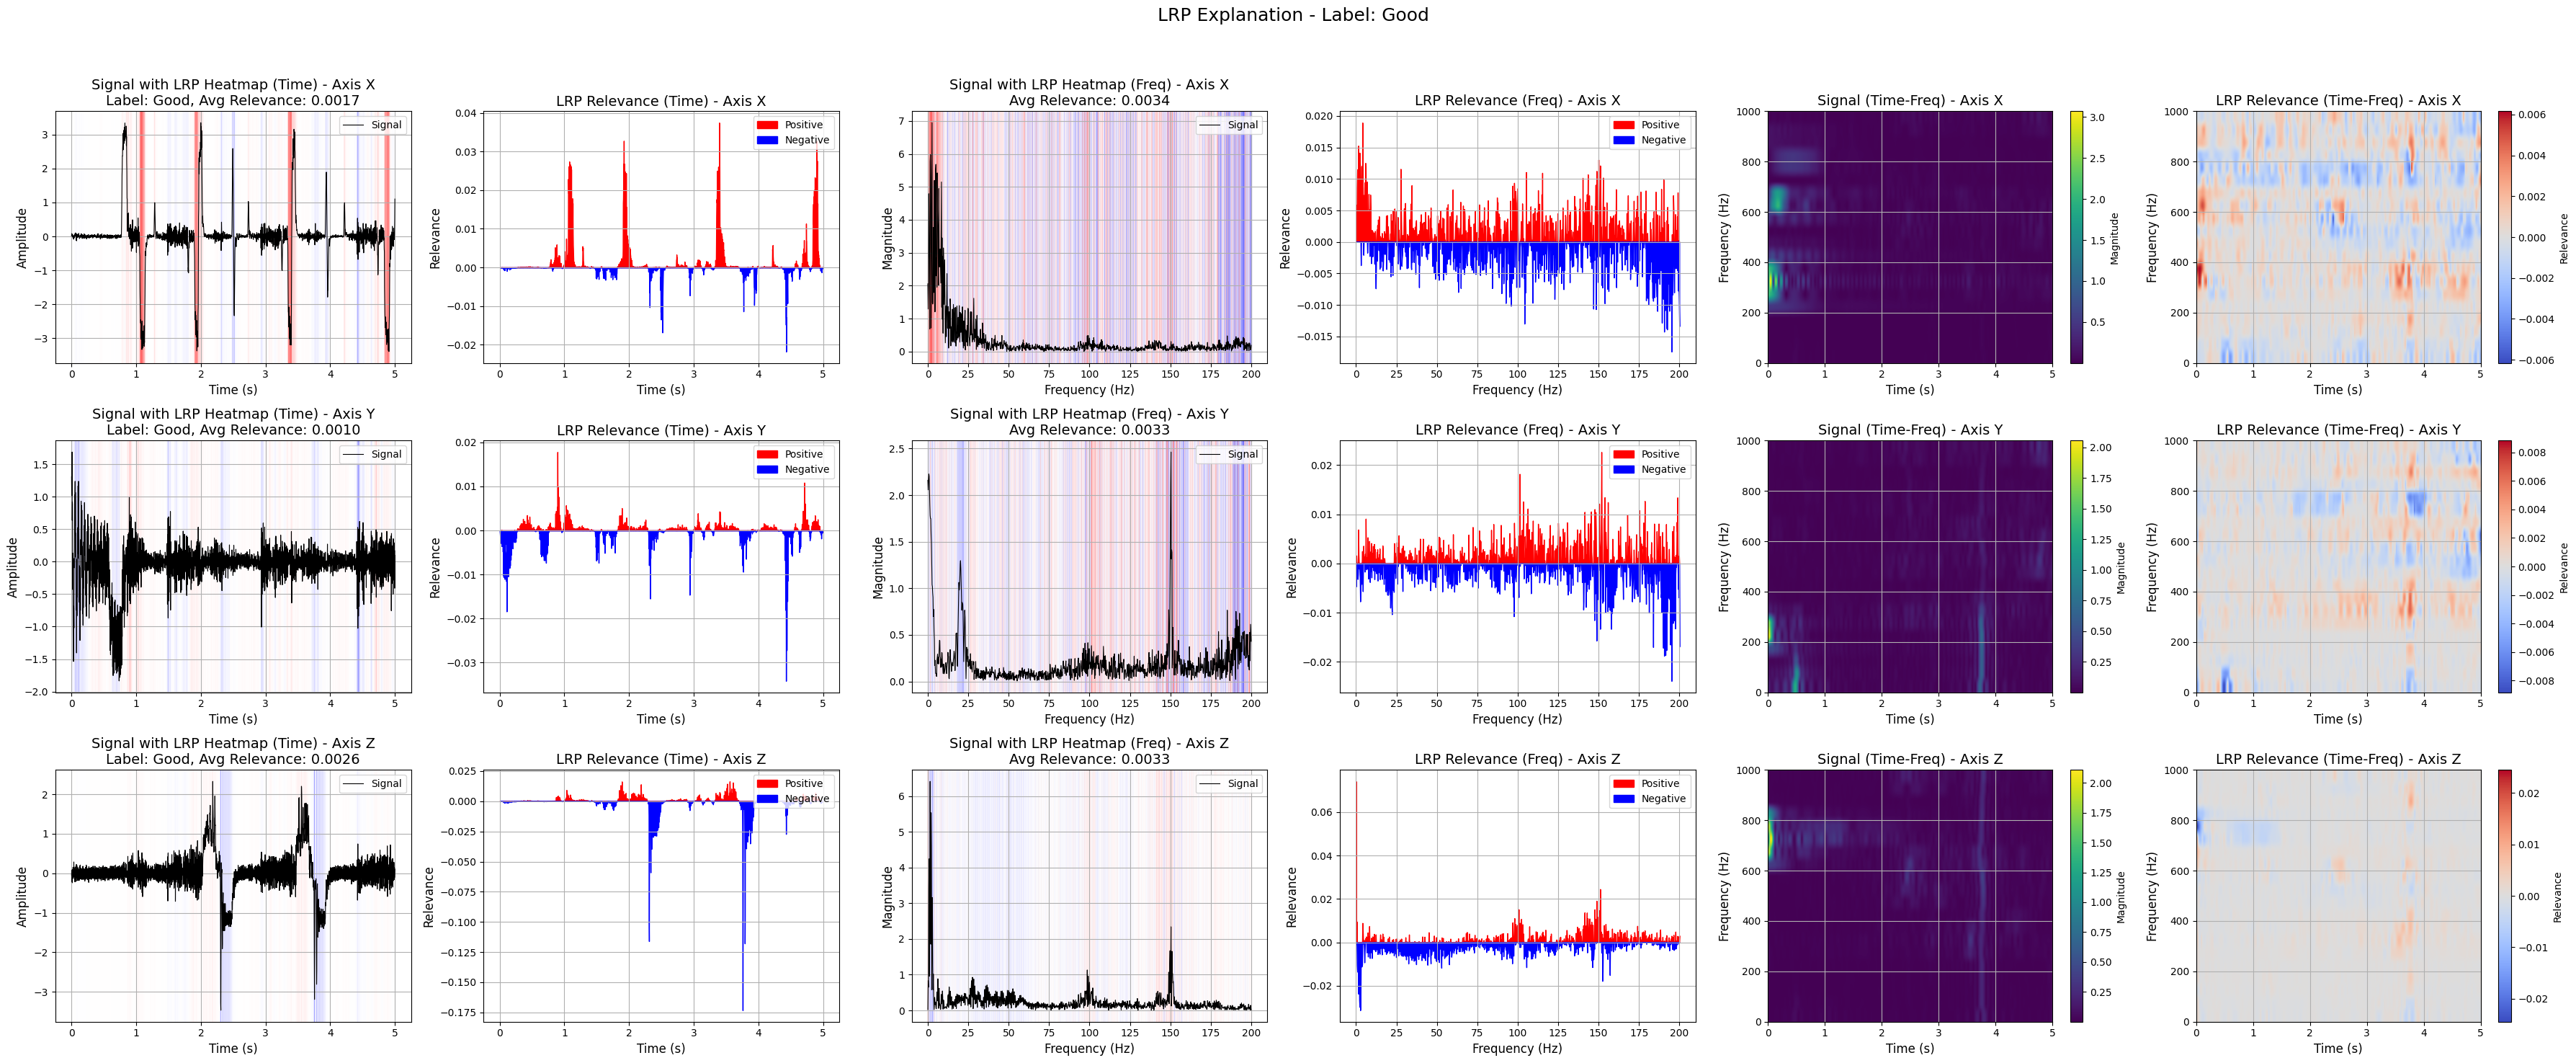

In [208]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time_fft,
    relevance_freq=relevance_freq_fft,
    signal_freq=signal_freq_fft,
    relevance_timefreq=relevance_timefreq_fft,
    signal_timefreq=signal_timefreq_fft,
    input_signal=input_signal_fft,
    freqs=freqs_fft,
    predicted_label=predicted_label_fft,
    signal_length=2000,
    sampling_rate=400,
    k_max=1000
)

Min relevance: -0.0306867528706789, Max relevance: 0.016755130141973495
 Maximum Absolute Attribution in Axis 0: 0.028730709105730057
 Maximum Absolute Attribution in Axis 1: 0.008504080586135387
 Maximum Absolute Attribution in Axis 2: 0.0306867528706789


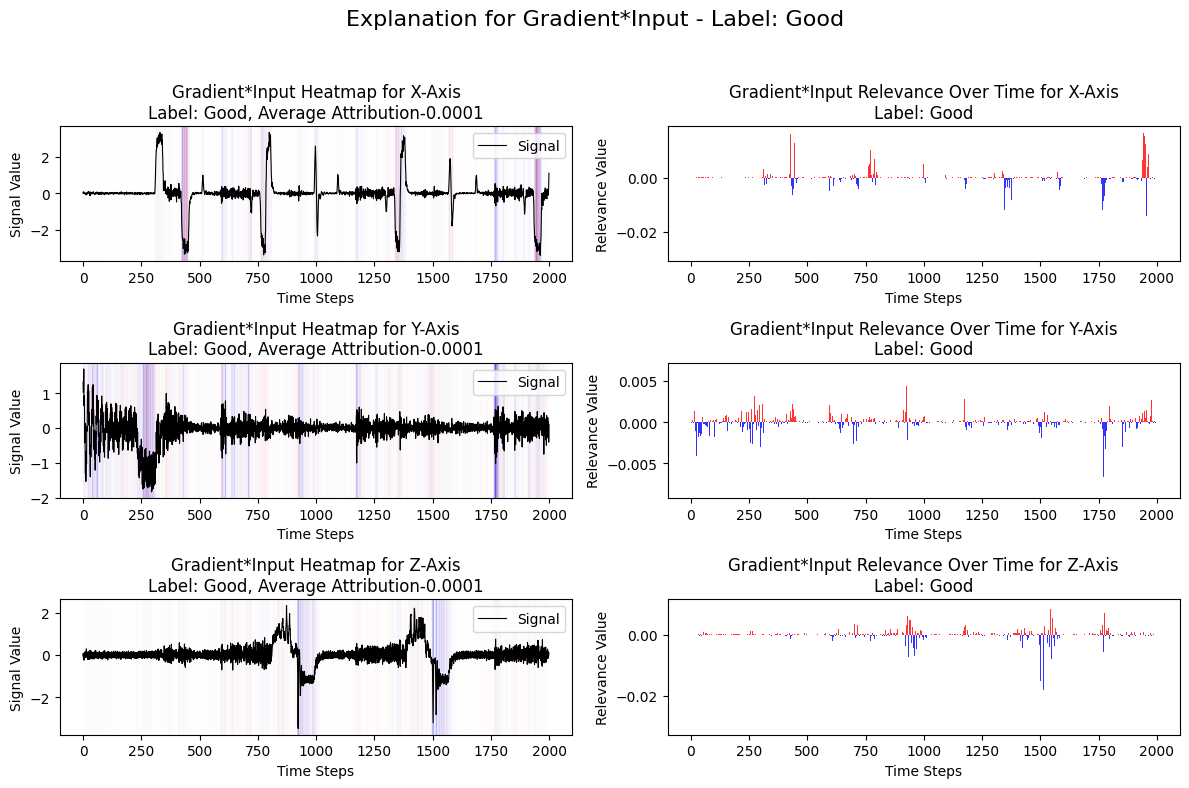

In [159]:
# Grad*Input
grad_input_attr, _ = grad_times_input_relevance(best_model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [160]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             958                  0.556348   
1  Axis 1             999                  0.331853   
2  Axis 2            1104                  0.544969   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000581            1042                 -0.800075   
1                    0.000332            1001                 -0.441759   
2                    0.000494             896                 -0.709025   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000768                    -0.243727   
1                   -0.000441                    -0.109907   
2                   -0.000791                    -0.164056   

   Average Relevance (Pos + Neg)  
0                      -0.000122  
1                      -0.000055  
2                      -0.000082  


Min relevance: -0.03419765830039978, Max relevance: 0.026249688118696213
 Maximum Absolute Attribution in Axis 0: 0.026249688118696213
 Maximum Absolute Attribution in Axis 1: 0.010848983190953732
 Maximum Absolute Attribution in Axis 2: 0.03419765830039978


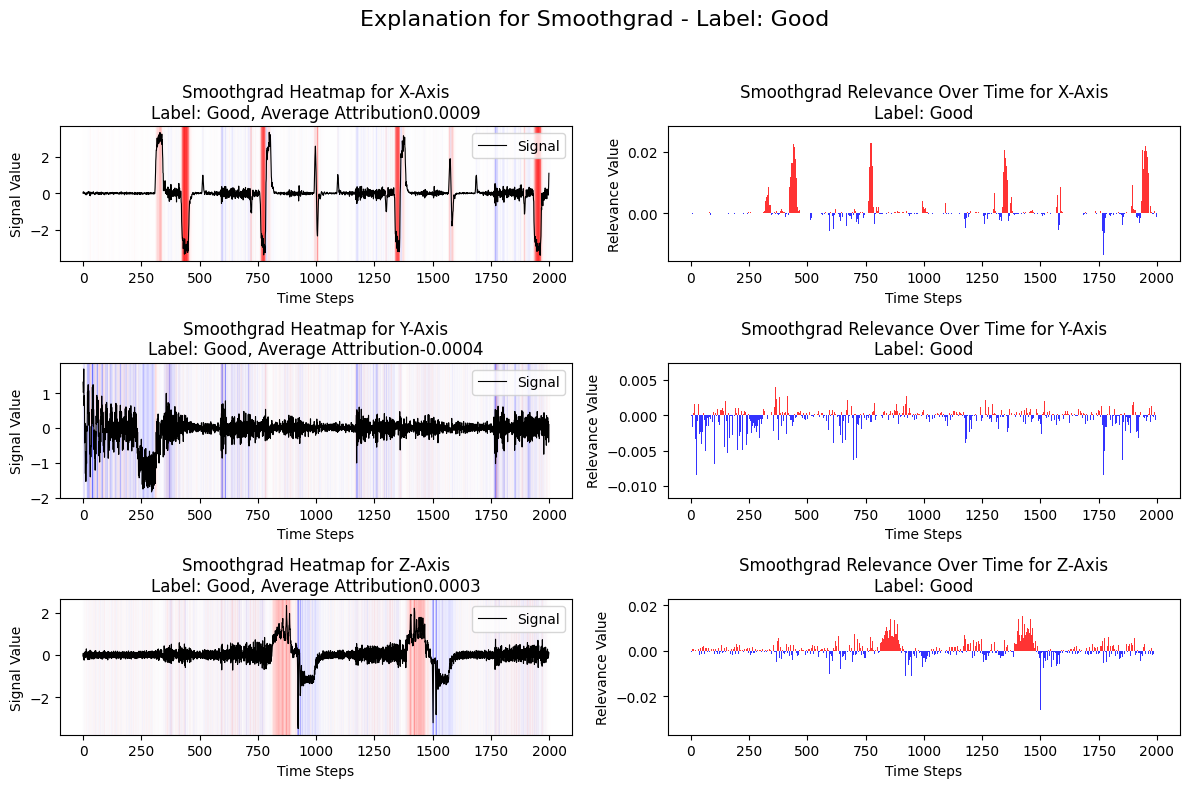

In [158]:

# SmoothGrad
smoothgrad_attr, _ = smoothgrad_relevance(best_model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.013675212860107422, Max relevance: 0.01514577865600586
 Maximum Absolute Attribution in Axis 0: 0.013675212860107422
 Maximum Absolute Attribution in Axis 1: 0.00995016098022461
 Maximum Absolute Attribution in Axis 2: 0.01514577865600586


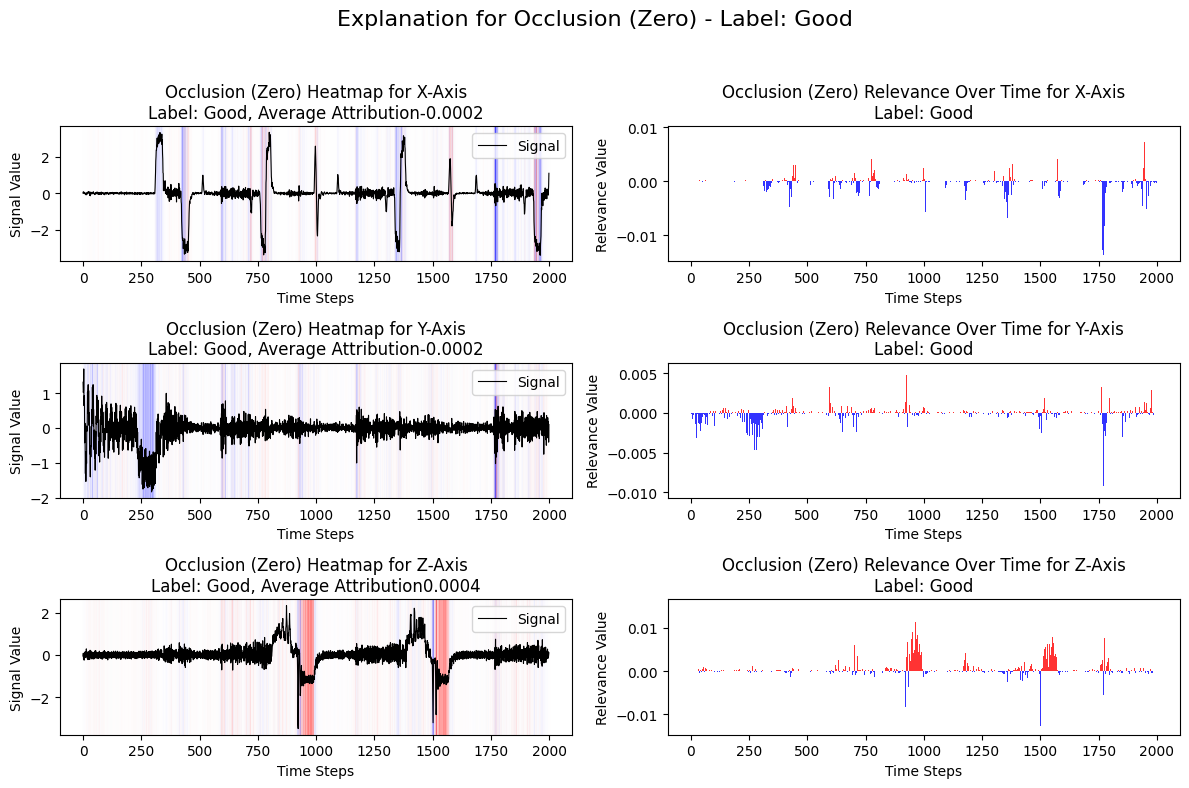

In [145]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.0904836654663086, Max relevance: 0.02179241180419922
 Maximum Absolute Attribution in Axis 0: 0.0904836654663086
 Maximum Absolute Attribution in Axis 1: 0.0904836654663086
 Maximum Absolute Attribution in Axis 2: 0.0904836654663086


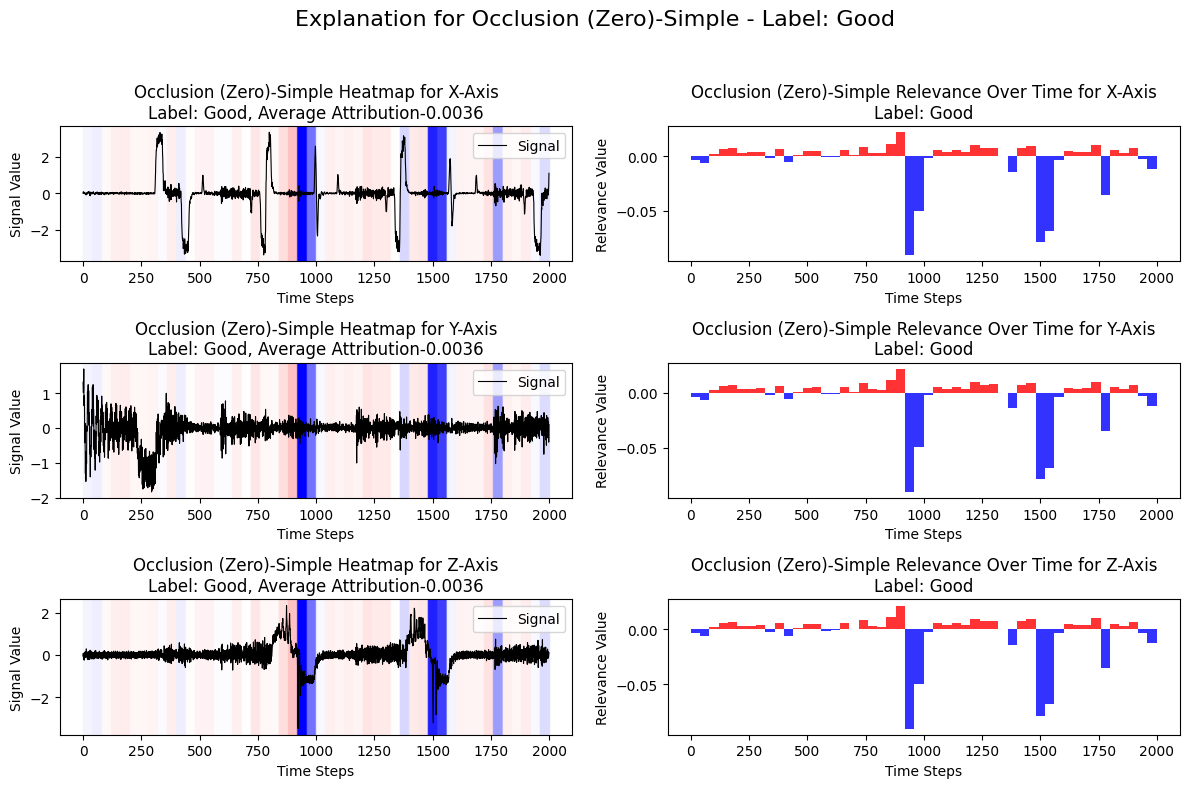

In [147]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.11140060424804688, Max relevance: 0.08320426940917969
 Maximum Absolute Attribution in Axis 0: 0.11140060424804688
 Maximum Absolute Attribution in Axis 1: 0.11140060424804688
 Maximum Absolute Attribution in Axis 2: 0.11140060424804688


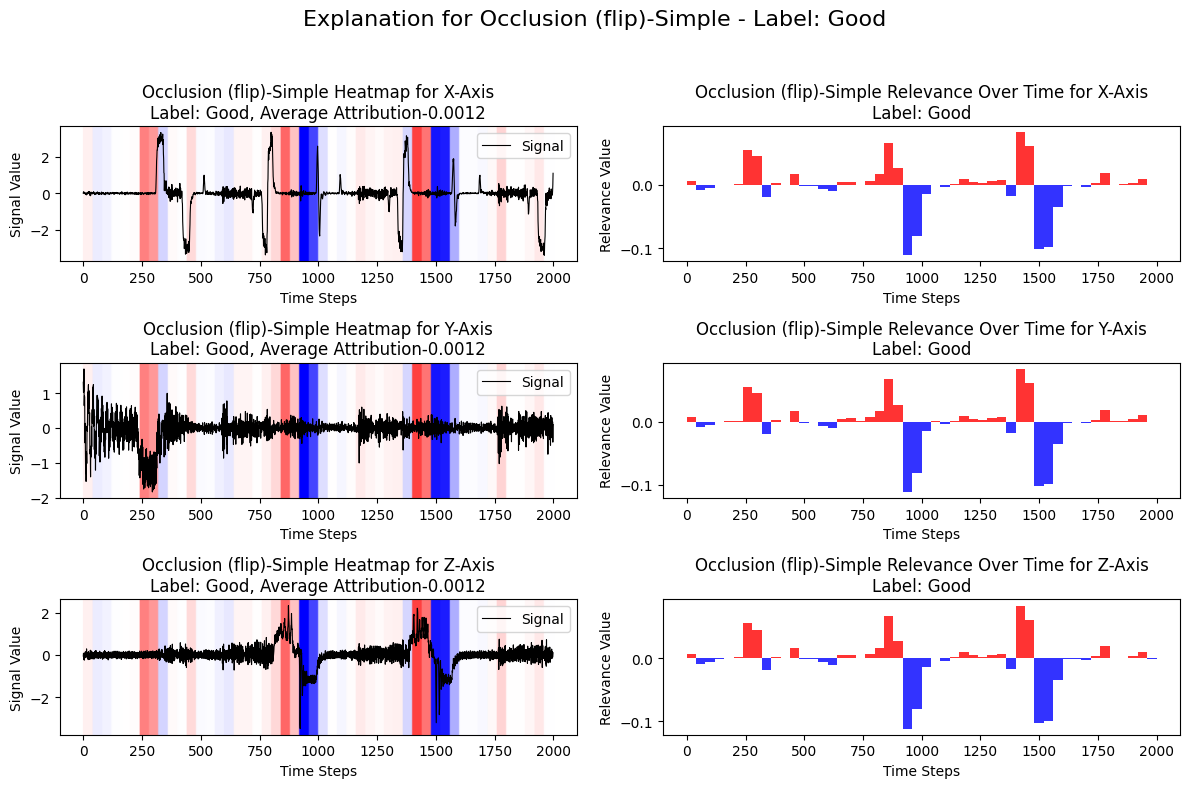

In [148]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = occlusion_simpler_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.04019498825073242, Max relevance: 0.030344486236572266
 Maximum Absolute Attribution in Axis 0: 0.04019498825073242
 Maximum Absolute Attribution in Axis 1: 0.033432960510253906
 Maximum Absolute Attribution in Axis 2: 0.030344486236572266


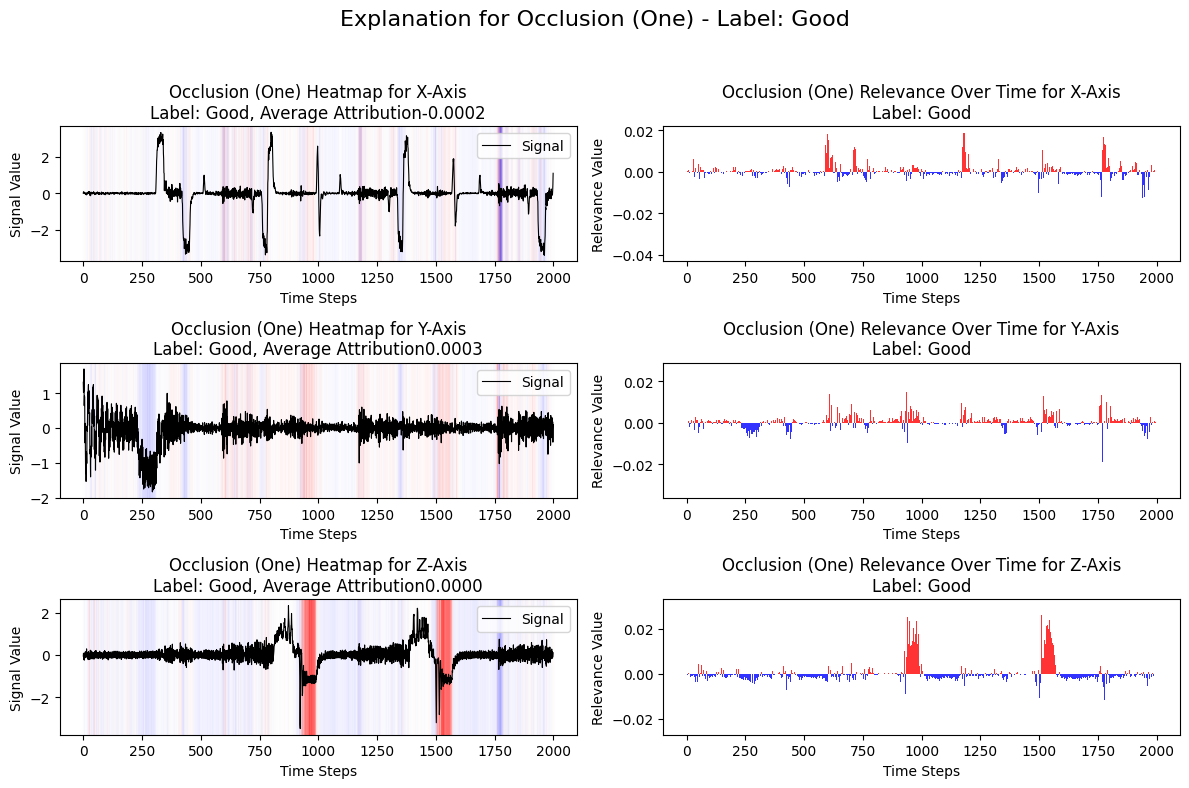

In [149]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.03960132598876953, Max relevance: 0.02590036392211914
 Maximum Absolute Attribution in Axis 0: 0.03960132598876953
 Maximum Absolute Attribution in Axis 1: 0.03830766677856445
 Maximum Absolute Attribution in Axis 2: 0.02590036392211914


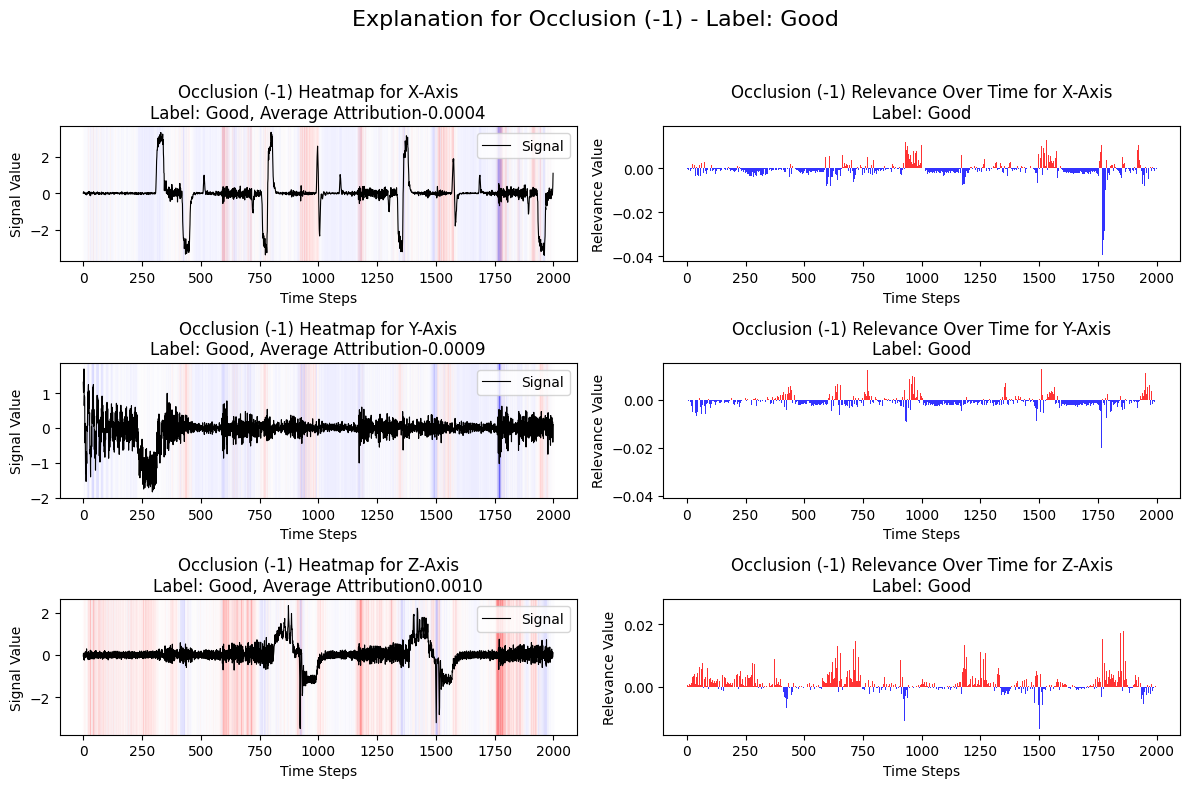

In [150]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.03304481506347656, Max relevance: 0.04747915267944336
 Maximum Absolute Attribution in Axis 0: 0.03304481506347656
 Maximum Absolute Attribution in Axis 1: 0.024022579193115234
 Maximum Absolute Attribution in Axis 2: 0.04747915267944336


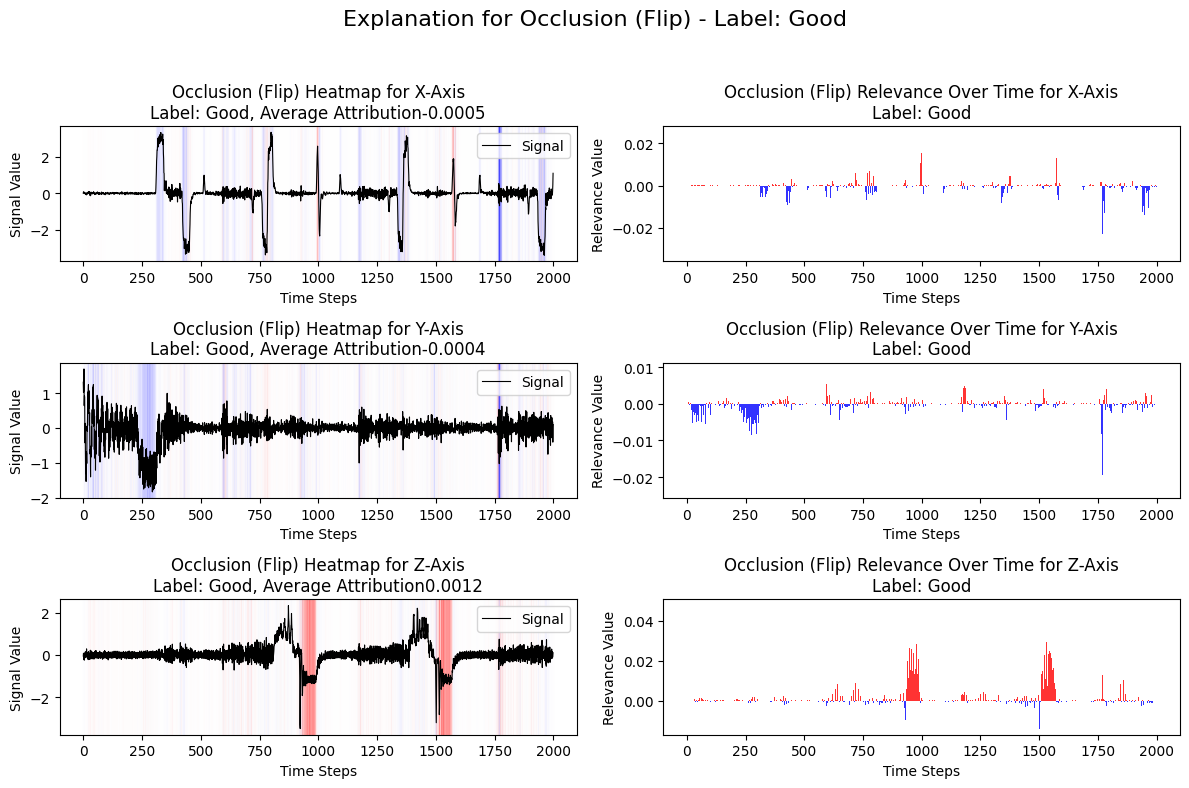

In [151]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = occlusion_signal_relevance(best_model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


In [80]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(best_model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}, True_label:{label_b}")
print(sample_b,sample_b.shape)


Random Index: 47, Predicted_label:1, True_label:1
tensor([[ 0.2993, -0.1354, -0.0537,  ..., -2.7708, -2.5485, -2.9614],
        [-0.7957, -0.0656,  0.6280,  ...,  0.5986, -0.9298,  1.2993],
        [ 1.1898, -1.2311,  0.6616,  ...,  0.2063, -0.9567, -0.0433]],
       device='cuda:0') torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 112 Label: Bad


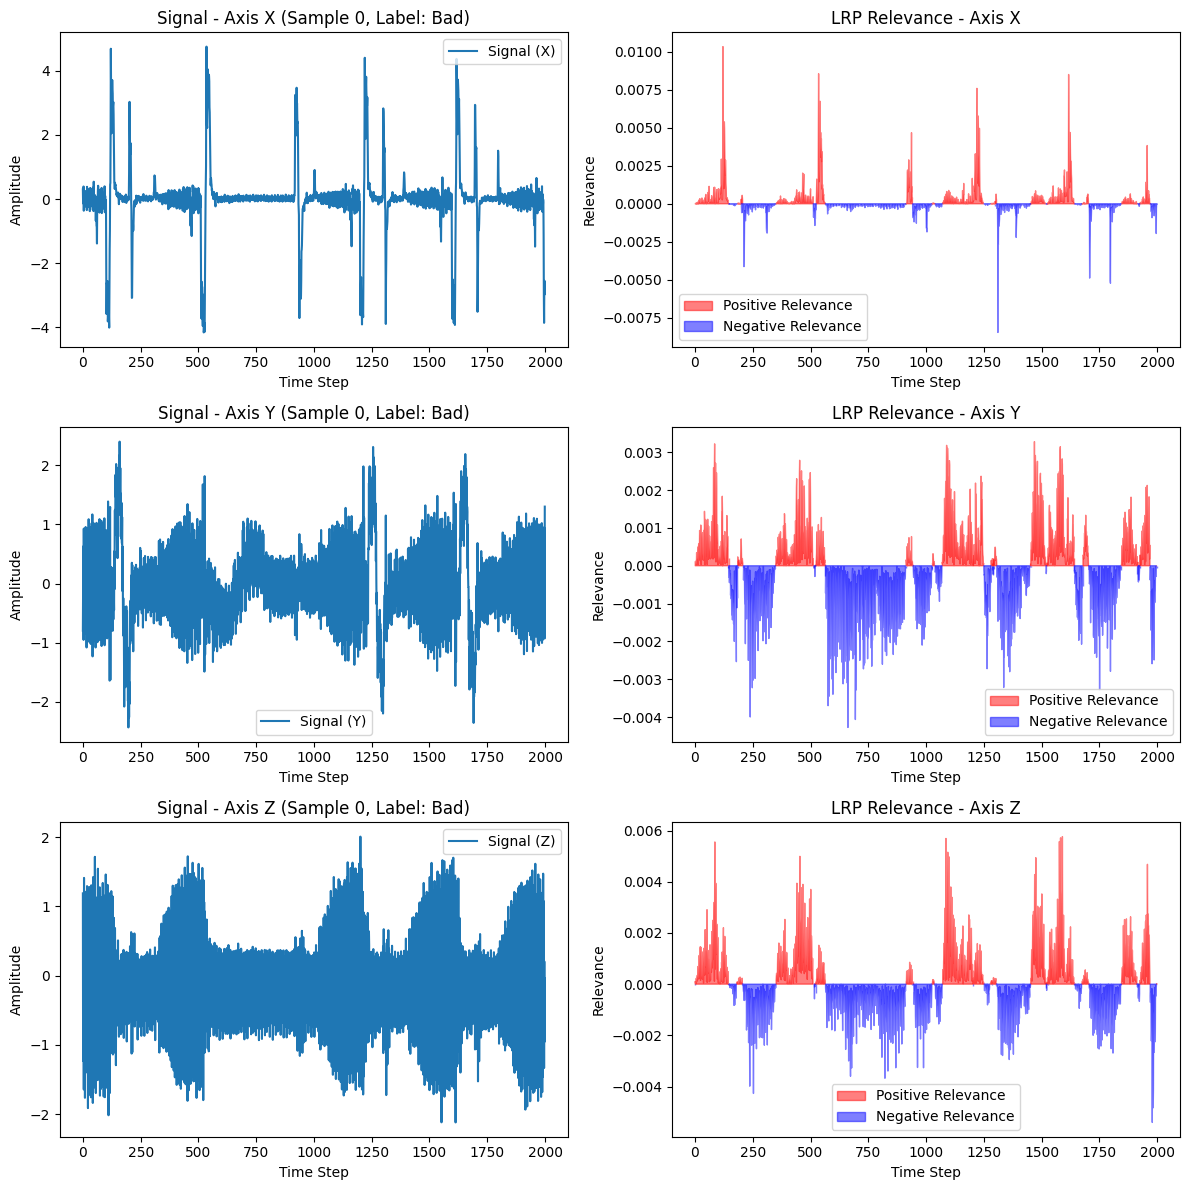

In [105]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=best_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.05911076068878174, Max relevance: 0.051815107464790344
 Maximum Absolute Attribution in Axis 0: 0.05911076068878174
 Maximum Absolute Attribution in Axis 1: 0.05573591589927673
 Maximum Absolute Attribution in Axis 2: 0.051815107464790344


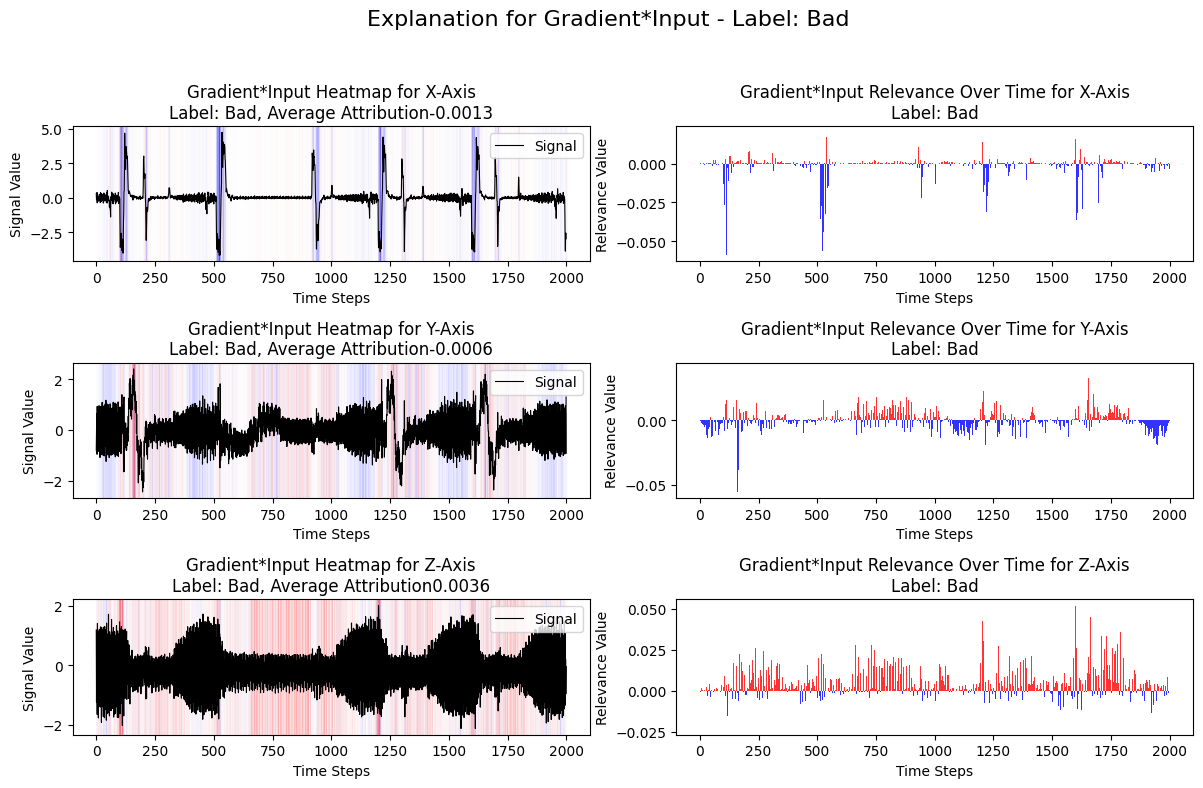

In [106]:
# Grad*Input
grad_input_attr_b, _ = grad_times_input_relevance(best_model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [107]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             966                  1.105637   
1  Axis 1             914                  4.408599   
2  Axis 2            1292                  9.183971   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001145            1034                 -3.758286   
1                    0.004823            1086                 -5.578635   
2                    0.007108             708                 -2.020416   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.003635                    -2.652649   
1                   -0.005137                    -1.170036   
2                   -0.002854                     7.163556   

   Average Relevance (Pos + Neg)  
0                      -0.001326  
1                      -0.000585  
2                       0.003582  


Min relevance: -0.020936278626322746, Max relevance: 0.013877716846764088
 Maximum Absolute Attribution in Axis 0: 0.020936278626322746
 Maximum Absolute Attribution in Axis 1: 0.005965872202068567
 Maximum Absolute Attribution in Axis 2: 0.013877716846764088


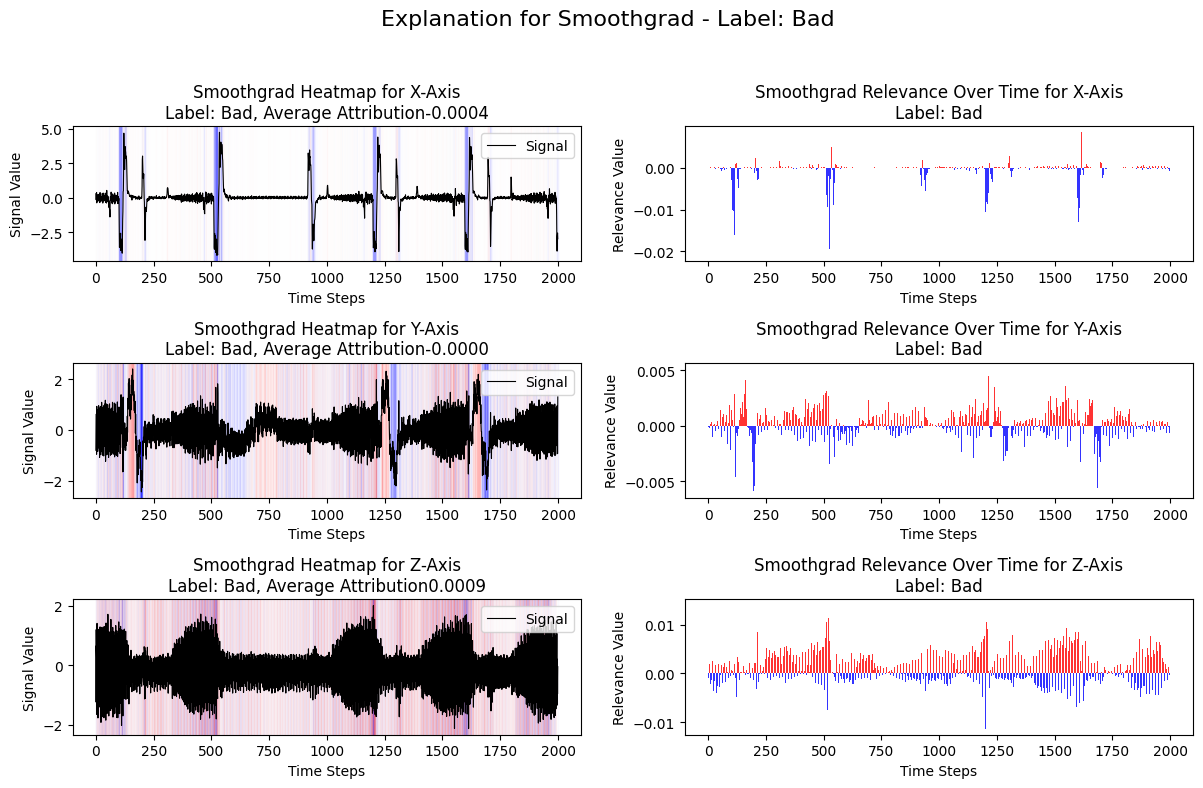

In [108]:
# SmoothGrad
smoothgrad_attr_b, _ = smoothgrad_relevance(best_model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [109]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1017                  0.226159   
1  Axis 1             982                  0.786579   
2  Axis 2            1079                  3.453308   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000222             983                 -0.968374   
1                    0.000801            1018                 -0.832371   
2                    0.003200             921                 -1.739345   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000985                    -0.742215   
1                   -0.000818                    -0.045791   
2                   -0.001889                     1.713964   

   Average Relevance (Pos + Neg)  
0                      -0.000371  
1                      -0.000023  
2                       0.000857  


Min relevance: -0.014760971069335938, Max relevance: 0.01059722900390625
 Maximum Absolute Attribution in Axis 0: 0.014760971069335938
 Maximum Absolute Attribution in Axis 1: 0.007761955261230469
 Maximum Absolute Attribution in Axis 2: 0.01059722900390625


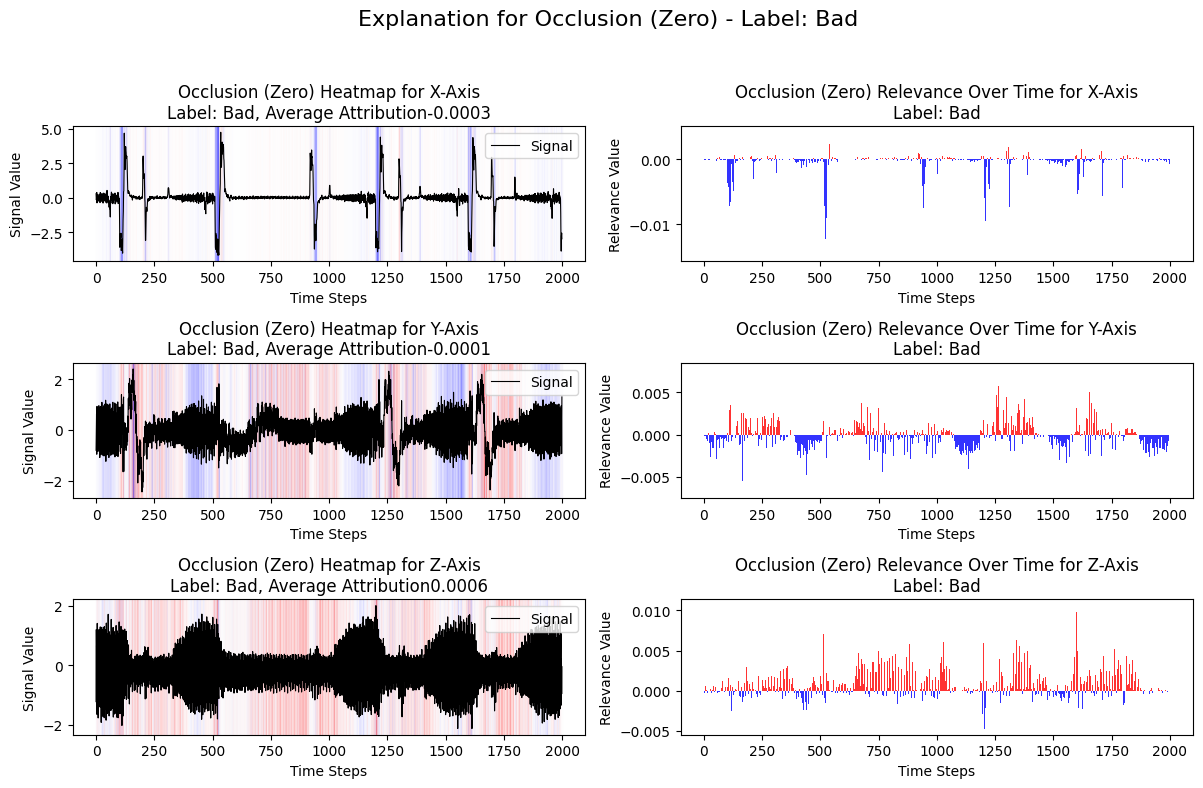

In [111]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.018676280975341797, Max relevance: 0.016756057739257812
 Maximum Absolute Attribution in Axis 0: 0.018676280975341797
 Maximum Absolute Attribution in Axis 1: 0.0095672607421875
 Maximum Absolute Attribution in Axis 2: 0.016756057739257812


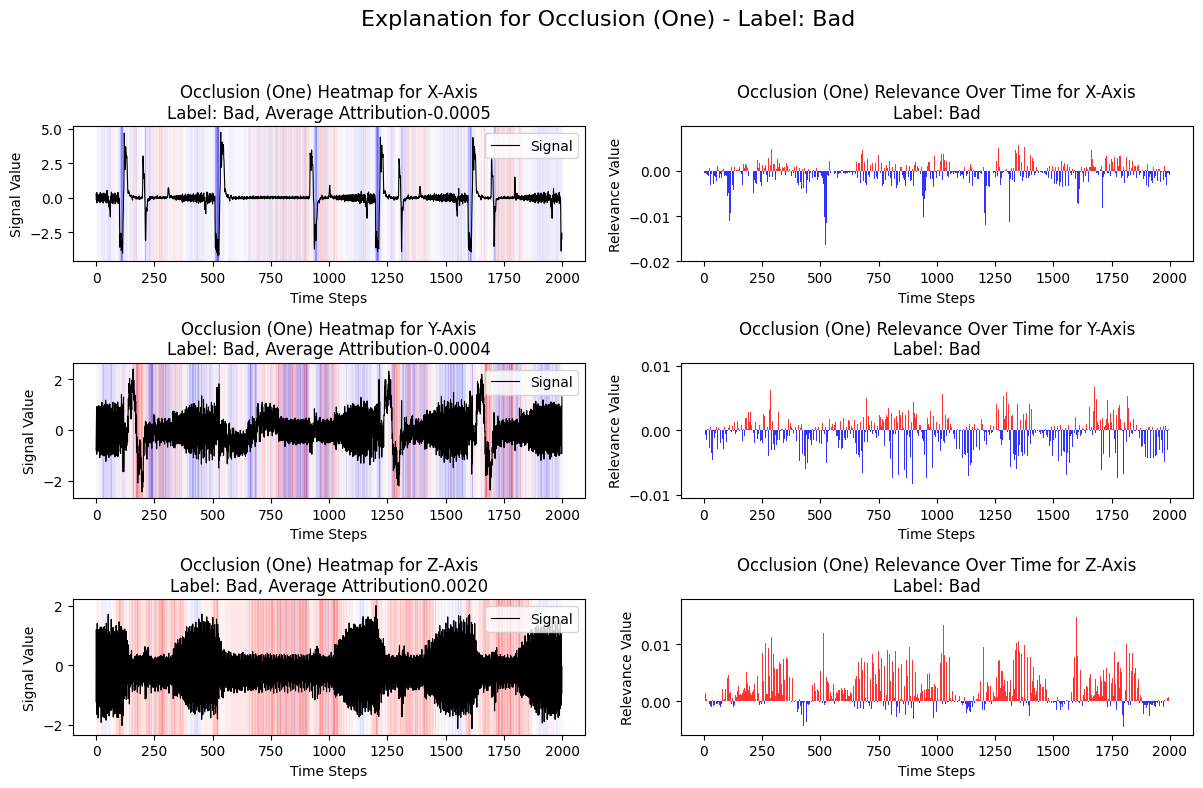

In [112]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.011278152465820312, Max relevance: 0.01508331298828125
 Maximum Absolute Attribution in Axis 0: 0.009991645812988281
 Maximum Absolute Attribution in Axis 1: 0.01508331298828125
 Maximum Absolute Attribution in Axis 2: 0.011278152465820312


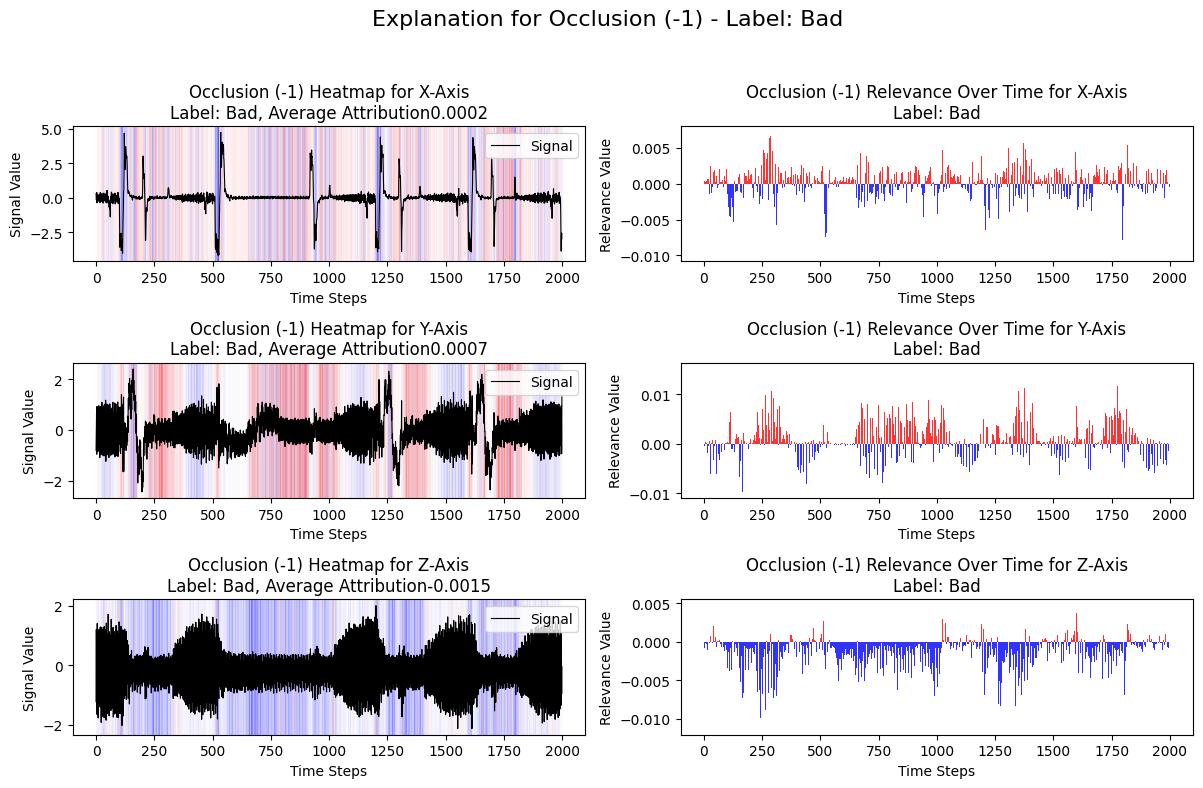

In [113]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = occlusion_signal_relevance(best_model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.029818058013916016, Max relevance: 0.019853591918945312
 Maximum Absolute Attribution in Axis 0: 0.029818058013916016
 Maximum Absolute Attribution in Axis 1: 0.012284278869628906
 Maximum Absolute Attribution in Axis 2: 0.019853591918945312


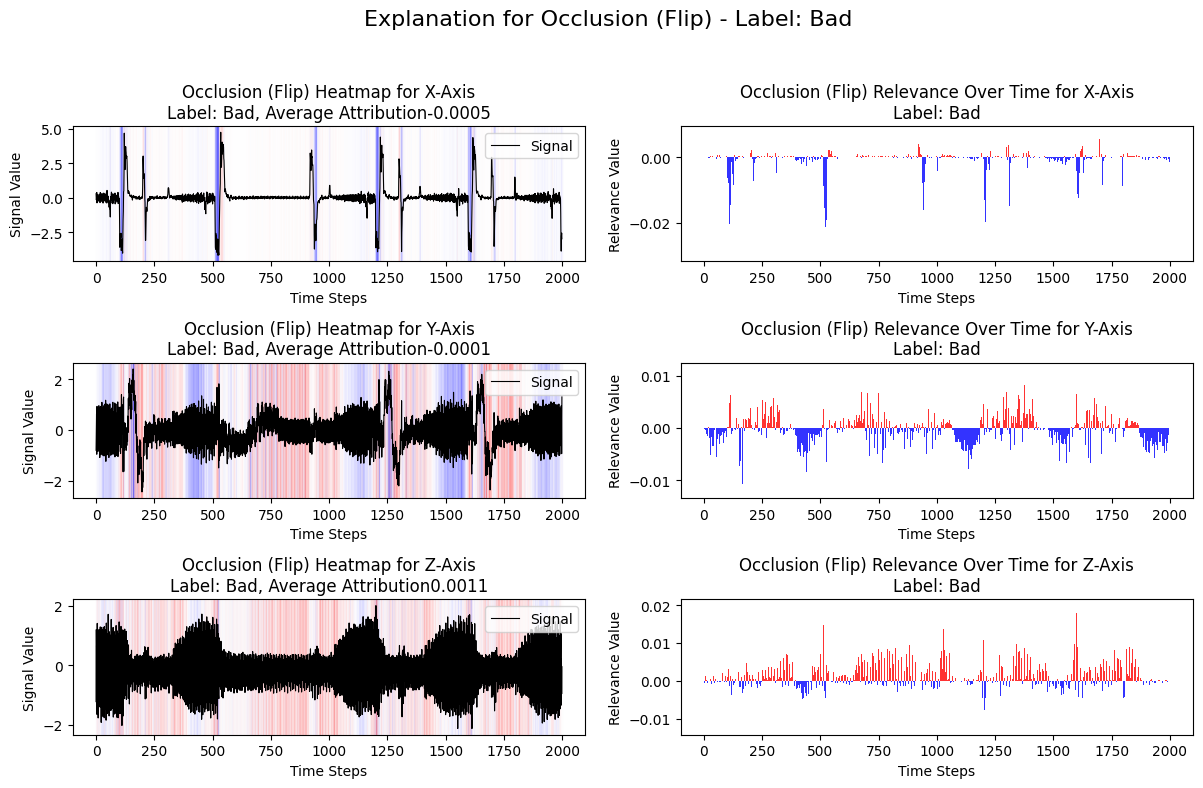

In [114]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = occlusion_signal_relevance(model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


Min relevance: -0.008469256572425365, Max relevance: 0.01034664735198021
 Maximum Absolute Attribution in Axis 0: 0.01034664735198021
 Maximum Absolute Attribution in Axis 1: 0.004271897487342358
 Maximum Absolute Attribution in Axis 2: 0.005766166839748621


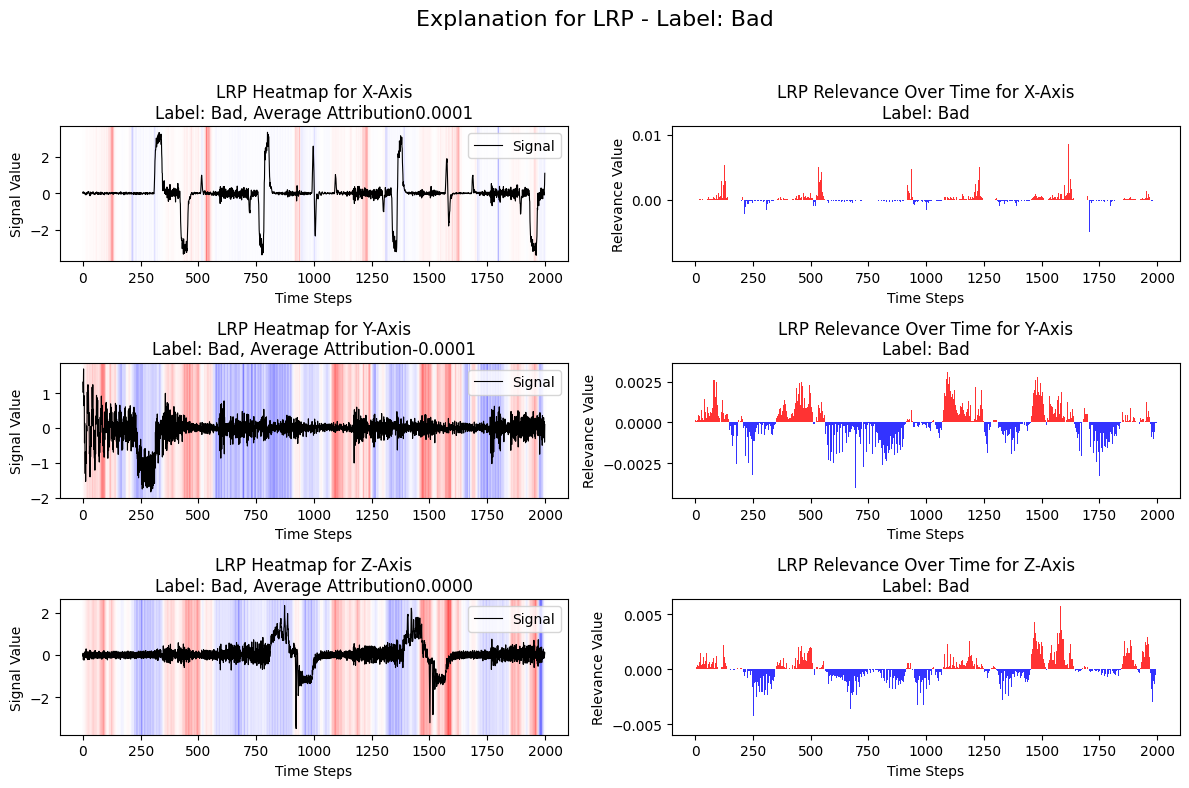

In [115]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample, relevance_b, label_b, "LRP")


In [116]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             965                  0.458088   
1  Axis 1             957                  1.956285   
2  Axis 2            1144                  3.210293   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000475            1032                 -1.515000   
1                    0.002044            1041                 -2.062155   
2                    0.002806             855                 -1.052492   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.001468                    -1.056912   
1                   -0.001981                    -0.105870   
2                   -0.001231                     2.157801   

   Average Relevance (Pos + Neg)  
0                      -0.000529  
1                      -0.000053  
2                       0.001079  


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 47 Label: Bad


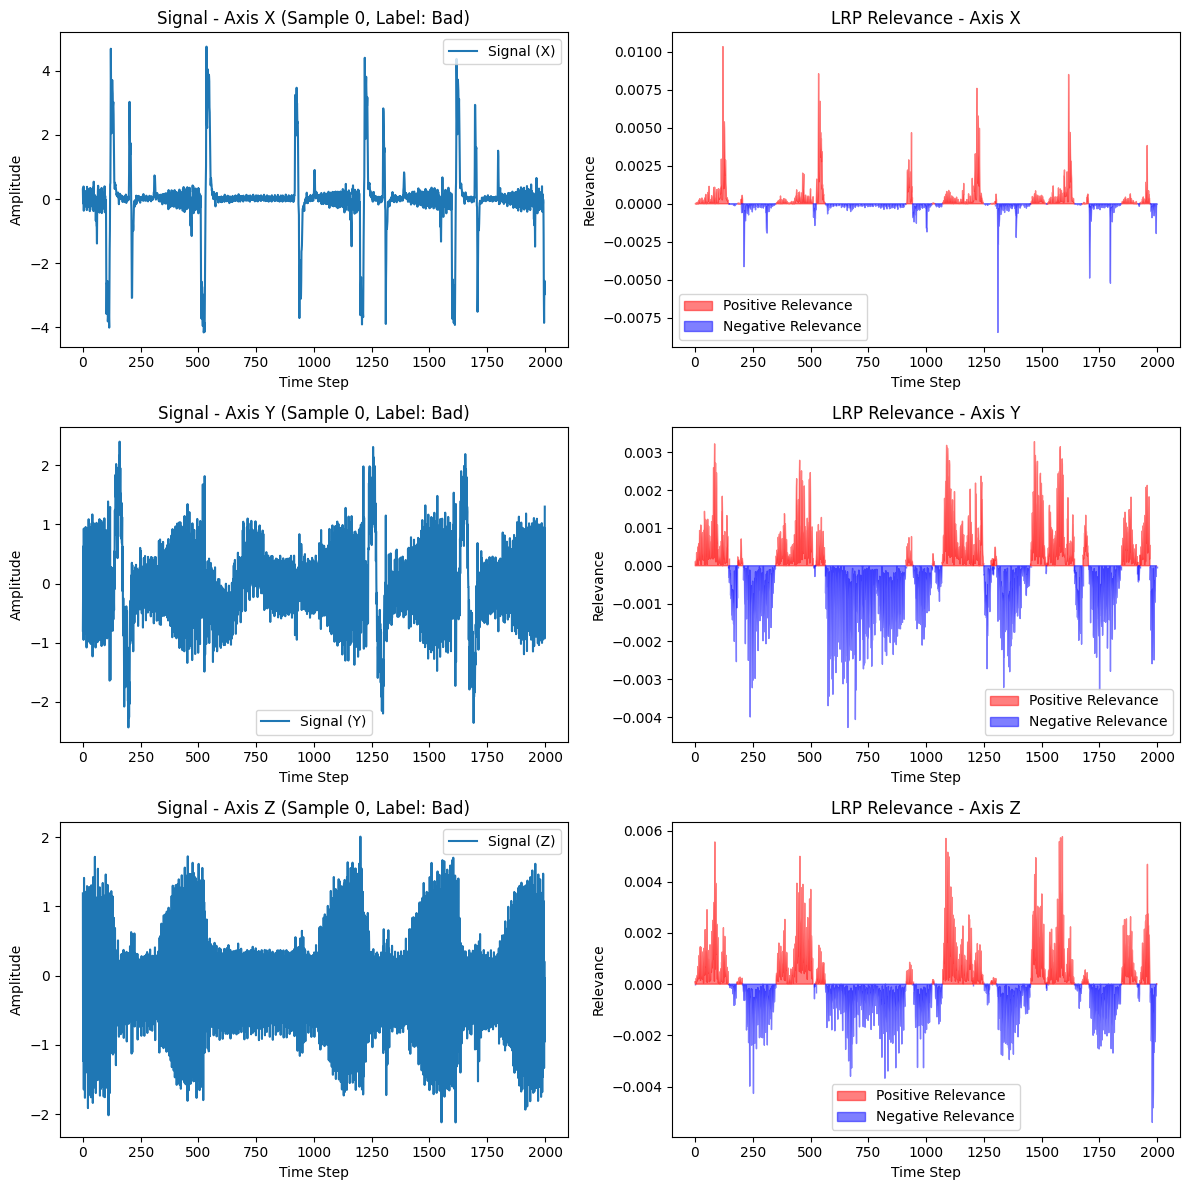

In [117]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance(
    model=best_model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index_b} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.008469256572425365, Max relevance: 0.01034664735198021
 Maximum Absolute Attribution in Axis 0: 0.01034664735198021
 Maximum Absolute Attribution in Axis 1: 0.004271897487342358
 Maximum Absolute Attribution in Axis 2: 0.005766167305409908


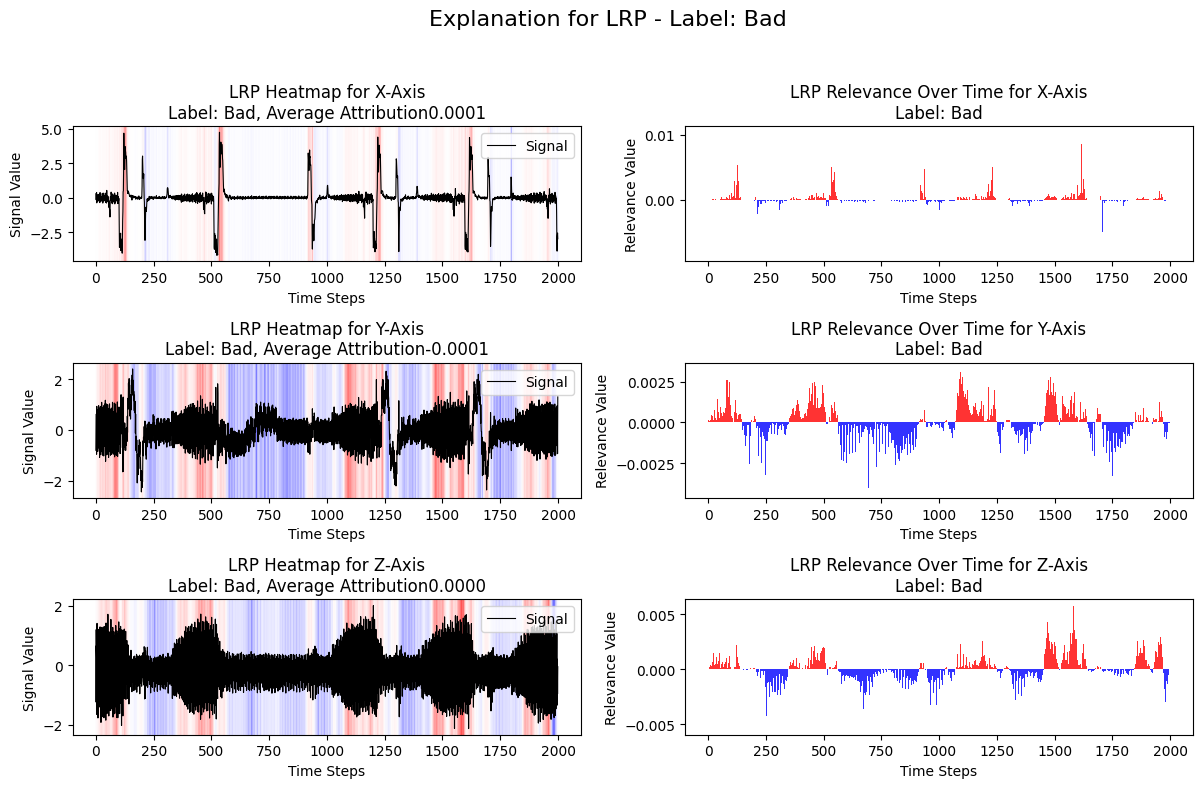

In [86]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [202]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_dft_lrp_relevance(
        model=best_model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Input sample shape: torch.Size([1, 3, 2000])
Relevance time shape: (3, 2000)
Input signal shape: (3, 2000)
Weight shape in create_fourier_weights: (2000, 1001)
Raw weight shape from dft_utils: (2000, 1001)
Weight shape after tensor conversion: torch.Size([1001, 2000])
Weight shape in create_fourier_weights: (1001, 2000)
Raw weight shape from dft_utils: (1001, 2000)
Weight shape after tensor conversion: torch.Size([1001, 2000])
Input signal shape: (1, 3, 2000)
Input relevance shape: (1, 3, 2000)
Signal hat shape after transform: torch.Size([3, 1001])
Relevance hat shape before multiplication: torch.Size([3, 1001])
Relevance hat shape after multiplication: torch.Size([3, 1001])
Expected freq_length: 1001
Signal shape after transform: (1, 3, 1001)
Relevance hat shape after transform: (1, 3, 1001)


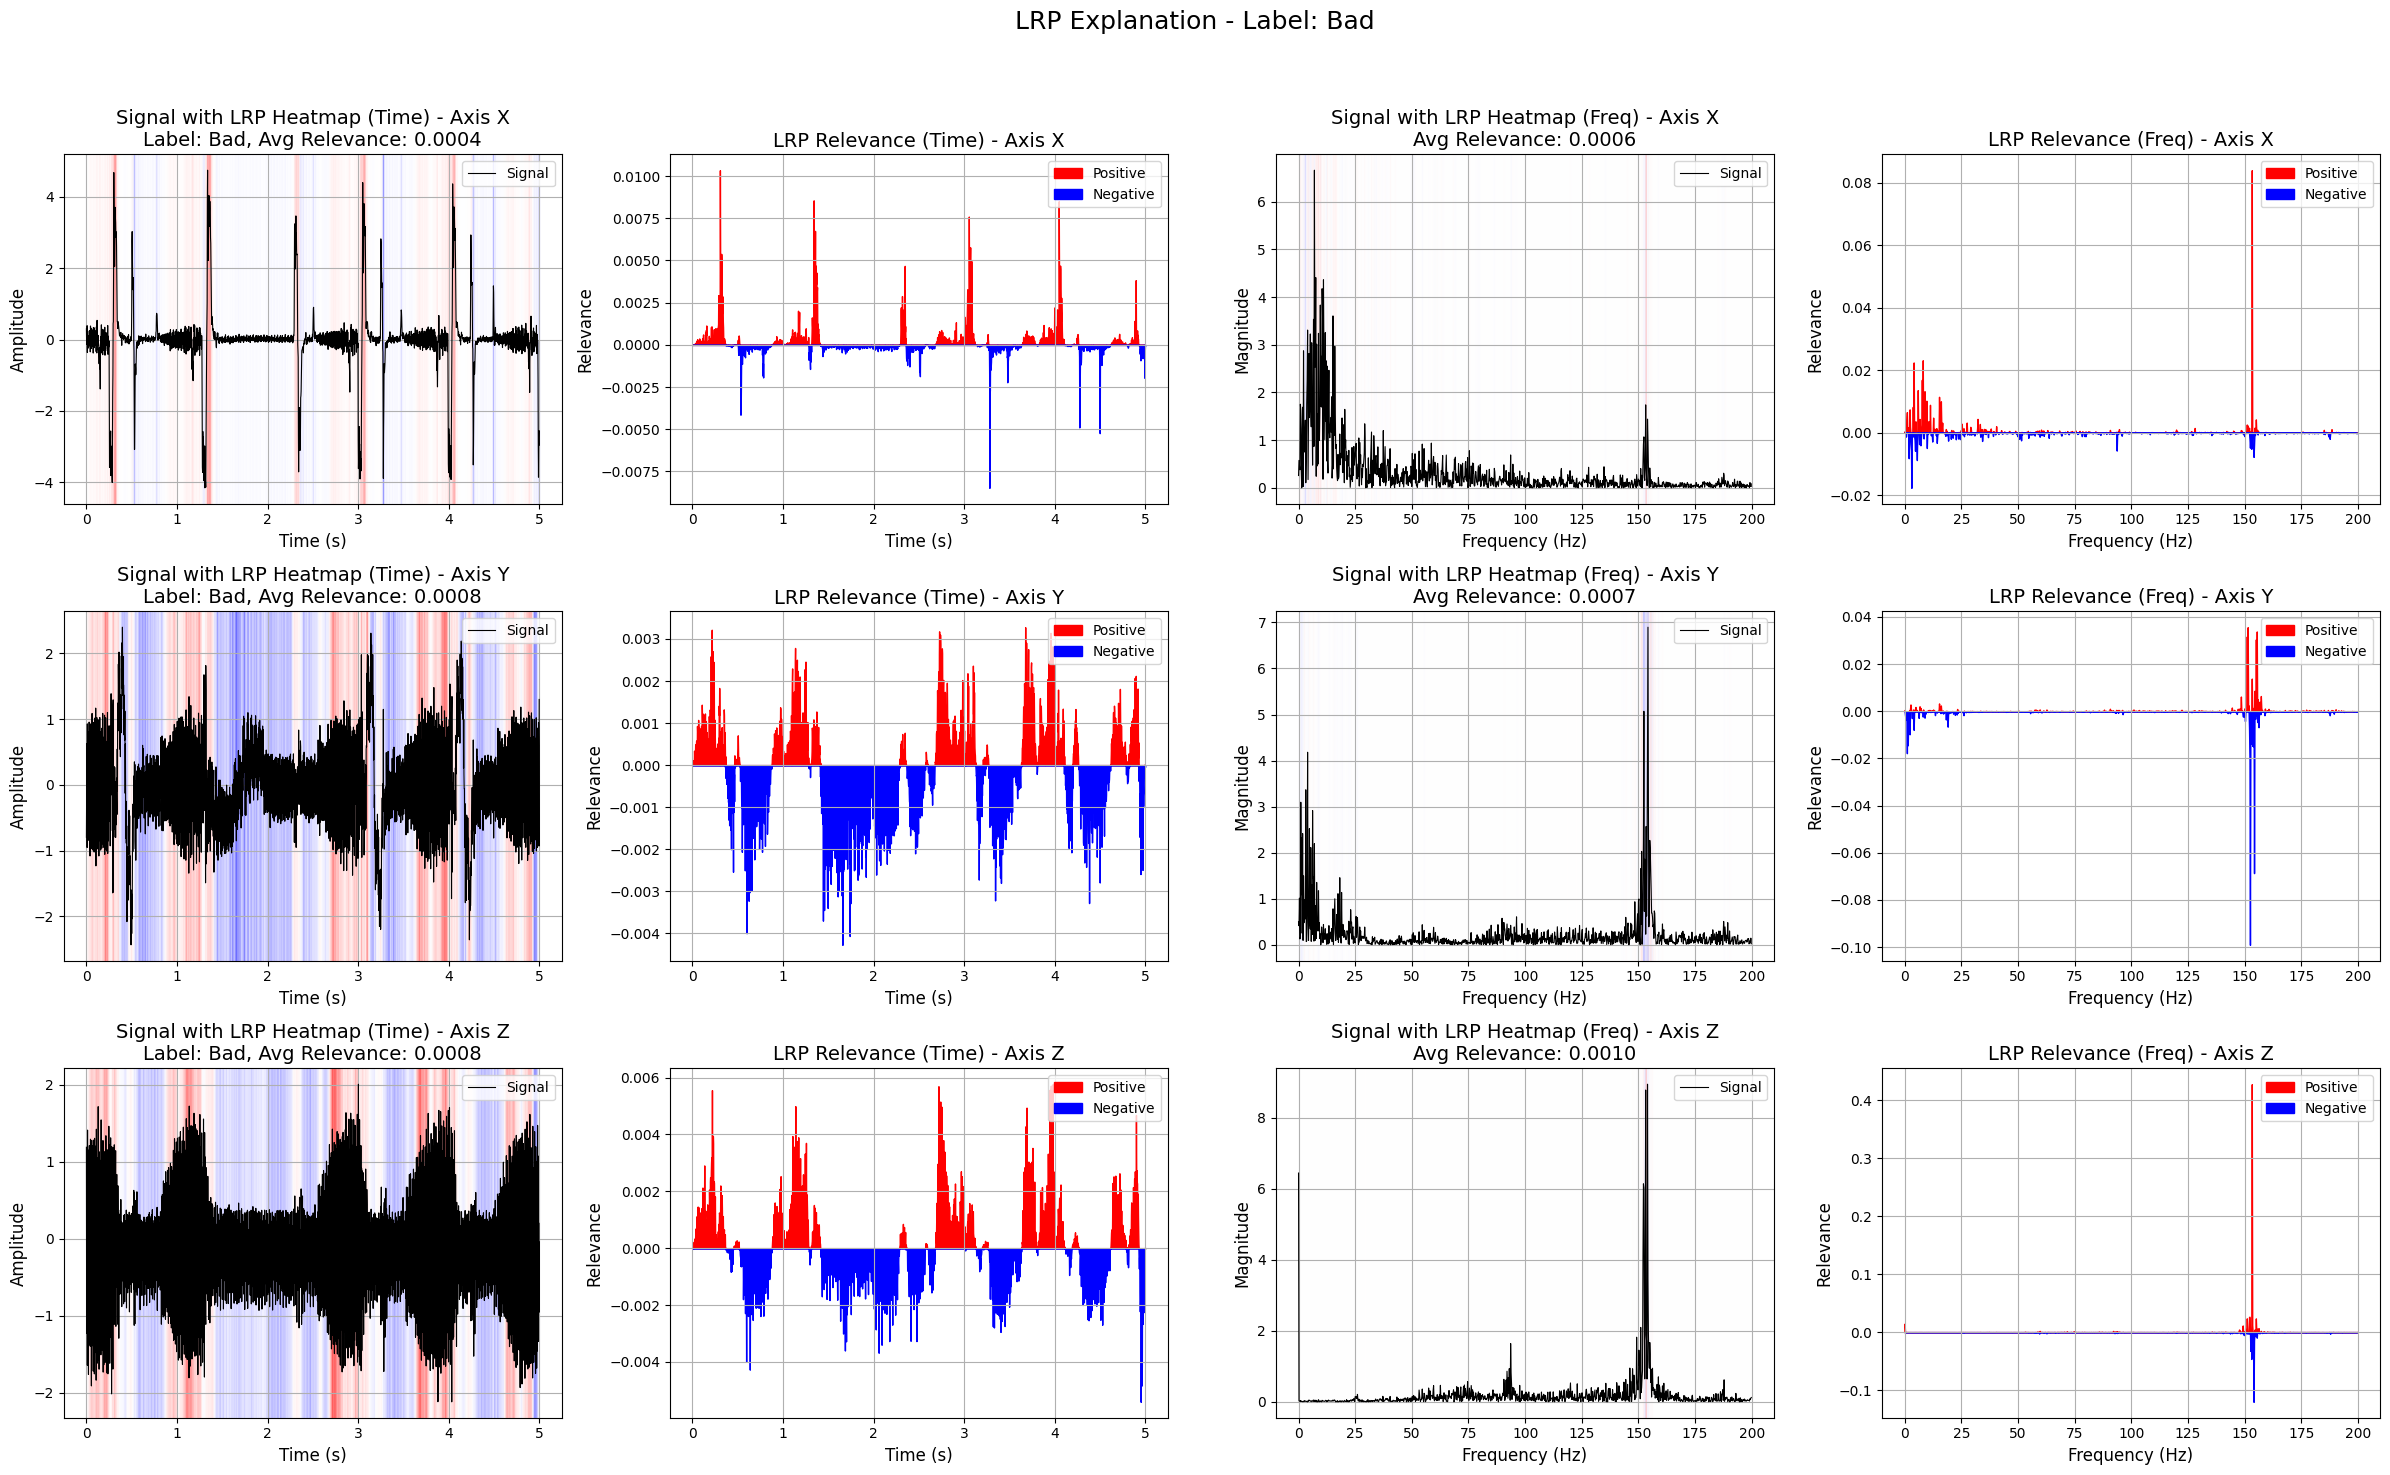

In [203]:
# Visualize the results
visualize_lrp_dft(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

In [204]:
summary_b_lrp = summarize_attributions( relevance_freq_b)  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_lrp = []
for axis, values in summary_b_lrp.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp.append(row)

# Create the DataFrame
df_summary_lrp = pd.DataFrame(data_lrp)

# Display the DataFrame as a table
print(df_summary_lrp)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             497                  0.412500   
1  Axis 1             494                  0.277062   
2  Axis 2             481                  0.680514   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000830             504                 -0.231553   
1                    0.000561             507                 -0.441829   
2                    0.001415             520                 -0.357188   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000459                     0.180947   
1                   -0.000871                    -0.164767   
2                   -0.000687                     0.323326   

   Average Relevance (Pos + Neg)  
0                       0.000181  
1                      -0.000165  
2                       0.000323  


In [205]:
""# Global Attribution over frequency with LRP
summary_lrp_t_b = summarize_attributions(relevance_time_b)  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_lrp_t_b = []
for axis, values in summary_lrp_t_b.items():
    row = {"Axis": axis}
    row.update(values)
    data_lrp_t_b.append(row)

# Create the DataFrame
df_summary_lrp_t_b = pd.DataFrame(data_lrp_t_b)

# Display the DataFrame as a table
print(df_summary_lrp_t_b)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             955                  0.489204   
1  Axis 1             947                  0.631273   
2  Axis 2             958                  0.875700   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000512            1045                 -0.220515   
1                    0.000667            1053                 -0.876566   
2                    0.000914            1042                 -0.789274   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000211                     0.268689   
1                   -0.000832                    -0.245293   
2                   -0.000757                     0.086426   

   Average Relevance (Pos + Neg)  
0                       0.000134  
1                      -0.000123  
2                       0.000043  
